In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import string
import matplotlib.dates as mdates

from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.optimize import basinhopping

from scipy import stats

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams['font.family']='Arial'

bar_width=0.25
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plt.rc('legend', fontsize=10)
plt.rc('figure', titlesize=12) 
# dateFmt = mdates.DateFormatter('%Y-%m-%d')
alphsize=12
alpha=0.4
padsize=15
set_dpi=600

In [4]:
savefolder='./figure'

## Data

In [5]:
data_ori=pd.read_excel('./data/heat_final_region.xlsx')

In [6]:
data_p2=data_ori[data_ori['year']>=2018]
data_p2.reset_index(drop=True, inplace=True)

In [7]:
data_loc2=pd.DataFrame([],columns=['date','case','tavg','tmax','rhum','wbgt'])

In [8]:
data_loc2['date']=data_p2['date'].unique()
data_loc2['case']=data_p2.groupby('date')['case'].sum(min_count=1).values
data_loc2['tavg']=data_p2.groupby('date')['tavg'].mean().values
data_loc2['tmax']=data_p2.groupby('date')['tmax'].max().values
data_loc2['rhum']=data_p2.groupby('date')['rhum'].mean().values
data_loc2['wbgt']=data_p2.groupby('date')['wbgt'].max().values
data_loc2['year']=data_loc2['date'].dt.year
data_loc2['month']=data_loc2['date'].dt.month

In [9]:
data_loc2['day']=data_loc2['date'].dt.day
data_loc2['late']=0
data_loc2.loc[data_loc2['day']>15,'late']=1
data_loc2['month2']=data_loc2['month']+data_loc2['late']*0.5

In [10]:
data_loc2['phase']=0
data_loc2.loc[data_loc2['month2']>=8.5,'phase']=1

## Figure 5. Hockey stick model

In [11]:
def hockey_stick(x, x0, b1, b2):
    return np.where(x < x0, b1, b2 * (x - x0) + b1)

def log_likelihood(params, x,y):
    x0, b1, b2 = params
    y_pred = hockey_stick(x, x0, b1, b2)
    return -np.sum(stats.poisson.logpmf(y, y_pred))

initial_params = [30, 0, 13]

In [12]:
data_loc2_drop=data_loc2.dropna()
data_loc2_drop.reset_index(drop=True, inplace=True)

In [13]:
data_loc2_zero=data_loc2.copy()
data_loc2_zero['case']=data_loc2_zero['case'].fillna(0)
# data_loc2['case'].fillna(0)

In [14]:
tmp=data_loc2_drop

minimizer_kwargs={"method":"SLSQP",
        # "method":"Nelder-Mead",
                  
        "bounds":((tmp['wbgt'].min(),tmp['wbgt'].max()),(0,None),(0,None)),
        "args":(tmp['wbgt'], tmp['case'])}
    
result = basinhopping(log_likelihood, initial_params, minimizer_kwargs=minimizer_kwargs, niter=1000,niter_success=100)

t0,b1,b2=result.x
x_fit=np.linspace(21,38,100)
y_fit=hockey_stick(x_fit,t0,b1,b2)

In [15]:
base_fit=y_fit
base_result=result.x

In [16]:
base_result

array([30.65646322,  2.79249467, 16.14122597])

In [17]:
num_params = len(result.x)  # Number of parameters (k)
log_likelihood_value = -log_likelihood(result.x, tmp['wbgt'], tmp['case'])
aic = 2 * num_params - 2 * log_likelihood_value

print(aic)

8597.814993967719


In [18]:
# tmp=data_loc2.dropna()
tmp1=data_loc2_drop.loc[data_loc2_drop['month2']<8.5]
tmp2=data_loc2_drop.loc[data_loc2_drop['month2']>=8.5]

minimizer_kwargs={"method":"SLSQP",
        # "method":"Nelder-Mead",
        "bounds":((tmp1['wbgt'].min(),tmp1['wbgt'].max()),(0,None),(None,None)),
        "args":(tmp1['wbgt'], tmp1['case'])}
    
result_p = basinhopping(log_likelihood, initial_params, minimizer_kwargs=minimizer_kwargs, niter=1000,niter_success=100)

t0_p,b1_p,b2_p=result_p.x
xp_fit=np.linspace(21,38,100)
yp_fit=hockey_stick(xp_fit,t0_p,b1_p,b2_p)

In [19]:
result_p.x

array([30.650776  ,  3.30612179, 17.29765779])

In [20]:
minimizer_kwargs={"method":"SLSQP",
        # "method":"Nelder-Mead",
        "bounds":((tmp2['wbgt'].min(),tmp2['wbgt'].max()),(0,None),(None,None)),
        "args":(tmp2['wbgt'], tmp2['case'])}

result_a = basinhopping(log_likelihood, initial_params, minimizer_kwargs=minimizer_kwargs, niter=1000,niter_success=100)
        
t0_a,b1_a,b2_a=result_a.x
xa_fit=np.linspace(21,38,100)
ya_fit=hockey_stick(xa_fit,t0_a,b1_a,b2_a)

In [21]:
result_a.x

array([30.2461849 ,  1.70068042,  7.63611848])

In [22]:
hs_model=pd.DataFrame(columns=['phase','t0','b1','b2'])
hs_model.loc[0]=['All',t0,b1,b2]
hs_model.loc[1]=['Phase 1',t0_p,b1_p,b2_p]
hs_model.loc[2]=['Phase 2',t0_a,b1_a,b2_a]

In [23]:
hs_model

phase         t0        b1         b2
0      All  30.656463  2.792495  16.141226
1  Phase 1  30.650776  3.306122  17.297658
2  Phase 2  30.246185  1.700680   7.636118

In [24]:
hs_model.to_excel('./result/hockey_stick_model.xlsx',index=False)

#### Region data

In [25]:
data_region=data_p2.copy()

In [26]:
data_region

date  case    region       tavg       tmax       rhum         tw  \
0     2018-05-20   0.0   Gangwon  13.028571  19.050000  61.992857  14.405095   
1     2018-05-21   0.0   Gangwon  14.292857  21.642857  68.342857  17.593487   
2     2018-05-22   0.0   Gangwon  15.842857  22.014286  79.607143  19.412132   
3     2018-05-23   1.0   Gangwon  17.078571  22.614286  64.100000  17.920322   
4     2018-05-24   0.0   Gangwon  19.164286  25.842857  50.007143  18.723924   
...          ...   ...       ...        ...        ...        ...        ...   
12859 2023-09-26   0.0  Chungbuk  19.833333  21.033333  94.616667  20.370694   
12860 2023-09-27   0.0  Chungbuk  21.050000  23.683333  92.100000  22.675936   
12861 2023-09-28   0.0  Chungbuk  21.400000  26.266667  81.600000  23.770725   
12862 2023-09-29   0.0  Chungbuk  19.566667  24.550000  80.300000  21.938395   
12863 2023-09-30   0.0  Chungbuk  18.200000  22.833333  80.700000  20.341653   

            wbgt  year  month  ...     60+  agri_area1  agri_area2  agri_pop  \
0      16.716861  2018      5  ...  405372       34170       67394    154098   
1      19.735073  2018      5  ...  405372       34170       67394    154098   
2      20.893121  2018      5  ...  405372       34170       67394    154098   
3      20.401001  2018      5  ...  405372       34170       67394    154098   
4      22.470110  2018      5  ...  405372       34170       67394    154098   
...          ...   ...    ...  ...     ...         ...         ...       ...   
12859  20.896694  2023      9  ...  471398       34655       60128    145053   
12860  23.463988  2023      9  ...  471398       34655       60128    145053   
12861  25.377737  2023      9  ...  471398       34655       60128    145053   
12862  23.526722  2023      9  ...  471398       34655       60128    145053   
12863  21.802929  2023      9  ...  471398       34655       60128    145053   

       simple_job_pop  pop_density    sex_rate  phase  elder_rate  metro  
0              246000     0.001478  101.385191      0         9.8      0  
1              246000     0.001478  101.385191      0         9.8      0  
2              246000     0.001478  101.385191      0         9.8      0  
3              246000     0.001478  101.385191      0         9.8      0  
4              246000     0.001478  101.385191      0         9.8      0  
...               ...          ...         ...    ...         ...    ...  
12859          245000     0.002183  103.490021      1        11.0      0  
12860          245000     0.002183  103.490021      1        11.0      0  
12861          245000     0.002183  103.490021      1        11.0      0  
12862          245000     0.002183  103.490021      1        11.0      0  
12863          245000     0.002183  103.490021      1        11.0      0  

[12864 rows x 29 columns]

In [27]:
metro_data=pd.DataFrame([],columns=['date','case','wbgt'])
urban_data=pd.DataFrame([],columns=['date','case','wbgt'])

In [28]:
tmp_data=data_region.groupby('metro').get_group(1)
metro_data['date']=tmp_data['date'].unique()
metro_data['case']=tmp_data.groupby('date')['case'].sum(min_count=1).values
metro_data['wbgt']=tmp_data.groupby('date')['wbgt'].max().values

In [29]:
tmp_data=data_region.groupby('metro').get_group(0)
urban_data['date']=tmp_data['date'].unique()
urban_data['case']=tmp_data.groupby('date')['case'].sum(min_count=1).values
urban_data['wbgt']=tmp_data.groupby('date')['wbgt'].max().values

In [30]:
metro_data['month2']=metro_data['date'].dt.month+metro_data['date'].dt.day/30
urban_data['month2']=urban_data['date'].dt.month+urban_data['date'].dt.day/30

metro_data['phase']=0
metro_data.loc[metro_data['month2']>=8+16/30,'phase']=1

urban_data['phase']=0
urban_data.loc[urban_data['month2']>=8+16/30,'phase']=1

metro_data['year']=metro_data['date'].dt.year
urban_data['year']=urban_data['date'].dt.year

In [31]:
resultm_list=[]
ym_fit_list=[]

metro_data_drop=metro_data.dropna()
urban_data_drop=urban_data.dropna()

for x in [metro_data_drop,urban_data_drop]:
    tmp=x
    minimizer_kwargs={"method":"SLSQP",
        # "method":"Nelder-Mead",
        "bounds":((tmp['wbgt'].min(),tmp['wbgt'].max()),(0,None),(0,None)),
        "args":(tmp['wbgt'],tmp['case'])}
    
    resultm = basinhopping(log_likelihood, initial_params, minimizer_kwargs=minimizer_kwargs, niter=1000,niter_success=100)
    th1,b1,b2=resultm.x
    
    x_fit=np.linspace(21,38,100)
    ym_fit=hockey_stick(x_fit,th1,b1,b2)
    ym_fit_list.append(ym_fit)
    resultm_list.append(resultm.x)
    
    print(resultm.x)

[31.11381077  0.75376001  5.38067379]
[29.91899765  2.20575197 12.01572478]


In [32]:
metero_name=['Seoul','Busan','Daegu','Incheon','Gwangju','Daejeon','Ulsan']
province_name=['Gyeonggi','Gangwon','Chungbuk','Chungnam','Jeonbuk','Jeonnam','Gyeongbuk','Gyeongnam','Jeju']
region_name=metero_name+province_name

In [33]:
result_region_list=[]
y_fit_region_list=[]

data_region_drop=data_region.dropna()
data_region_drop.reset_index(drop=True, inplace=True)

for x in region_name:
    tmp=data_region_drop[data_region_drop['region']==x]
    minimizer_kwargs={"method":"SLSQP",
        # "method":"Nelder-Mead",
        "bounds":((tmp['wbgt'].min(),tmp['wbgt'].max()),(0,None),(0,None)),
        "args":(tmp['wbgt'],tmp['case'])}
    
    result_region = basinhopping(log_likelihood, initial_params, minimizer_kwargs=minimizer_kwargs, niter=1000,niter_success=100)
    th1,b1,b2=result_region.x
    
    x_fit=np.linspace(21,38,100)
    y_fit_region=hockey_stick(x_fit,th1,b1,b2)
    y_fit_region_list.append(y_fit_region)
    result_region_list.append(result_region.x)
    
    print(x,result_region.x)

Seoul [29.59619652  0.24736842  2.58328402]
Busan [28.65398945  0.1029963   1.23336448]
Daegu [29.61969183  0.04821812  0.37230503]
Incheon [27.65807179  0.15362241  1.55694055]
Gwangju [30.02642279  0.07407423  0.42182335]
Daejeon [29.71588527  0.04715165  0.30780738]
Ulsan [28.36466617  0.05846759  0.37206074]
Gyeonggi [29.67606747  0.73636362  4.91171496]
Gangwon [28.4273463   0.17276016  0.99266376]
Chungbuk [29.15373887  0.13407822  1.04135899]
Chungnam [29.03235221  0.20352247  1.45100326]
Jeonbuk [28.86331957  0.151064    1.05447906]
Jeonnam [28.50969167  0.31262929  1.52060405]
Gyeongbuk [28.2778193   0.26096031  1.30224787]
Gyeongnam [29.13312776  0.2558141   1.59706239]
Jeju [27.28498284  0.08703638  0.44373931]


In [34]:
compare_df=pd.DataFrame([],index=region_name,columns=['min','mean','max', 'median'])
compare_df['mean']=data_region_drop.groupby('region')['wbgt'].mean()[region_name]
compare_df['min']=data_region_drop.groupby('region')['wbgt'].min()[region_name]
compare_df['max']=data_region_drop.groupby('region')['wbgt'].max()[region_name]
compare_df['median']=data_region_drop.groupby('region')['wbgt'].median()[region_name]

hs_per_df=pd.DataFrame(result_region_list,index=region_name,columns=['t0','b1','b2'])

compare_df['t0']=hs_per_df['t0']
compare_df['b1']=hs_per_df['b1']
compare_df['b2']=hs_per_df['b2']

compare_df['metro']=0
compare_df.loc[metero_name,'metro']=1

In [35]:
func = lambda x, a, b: a * x + b

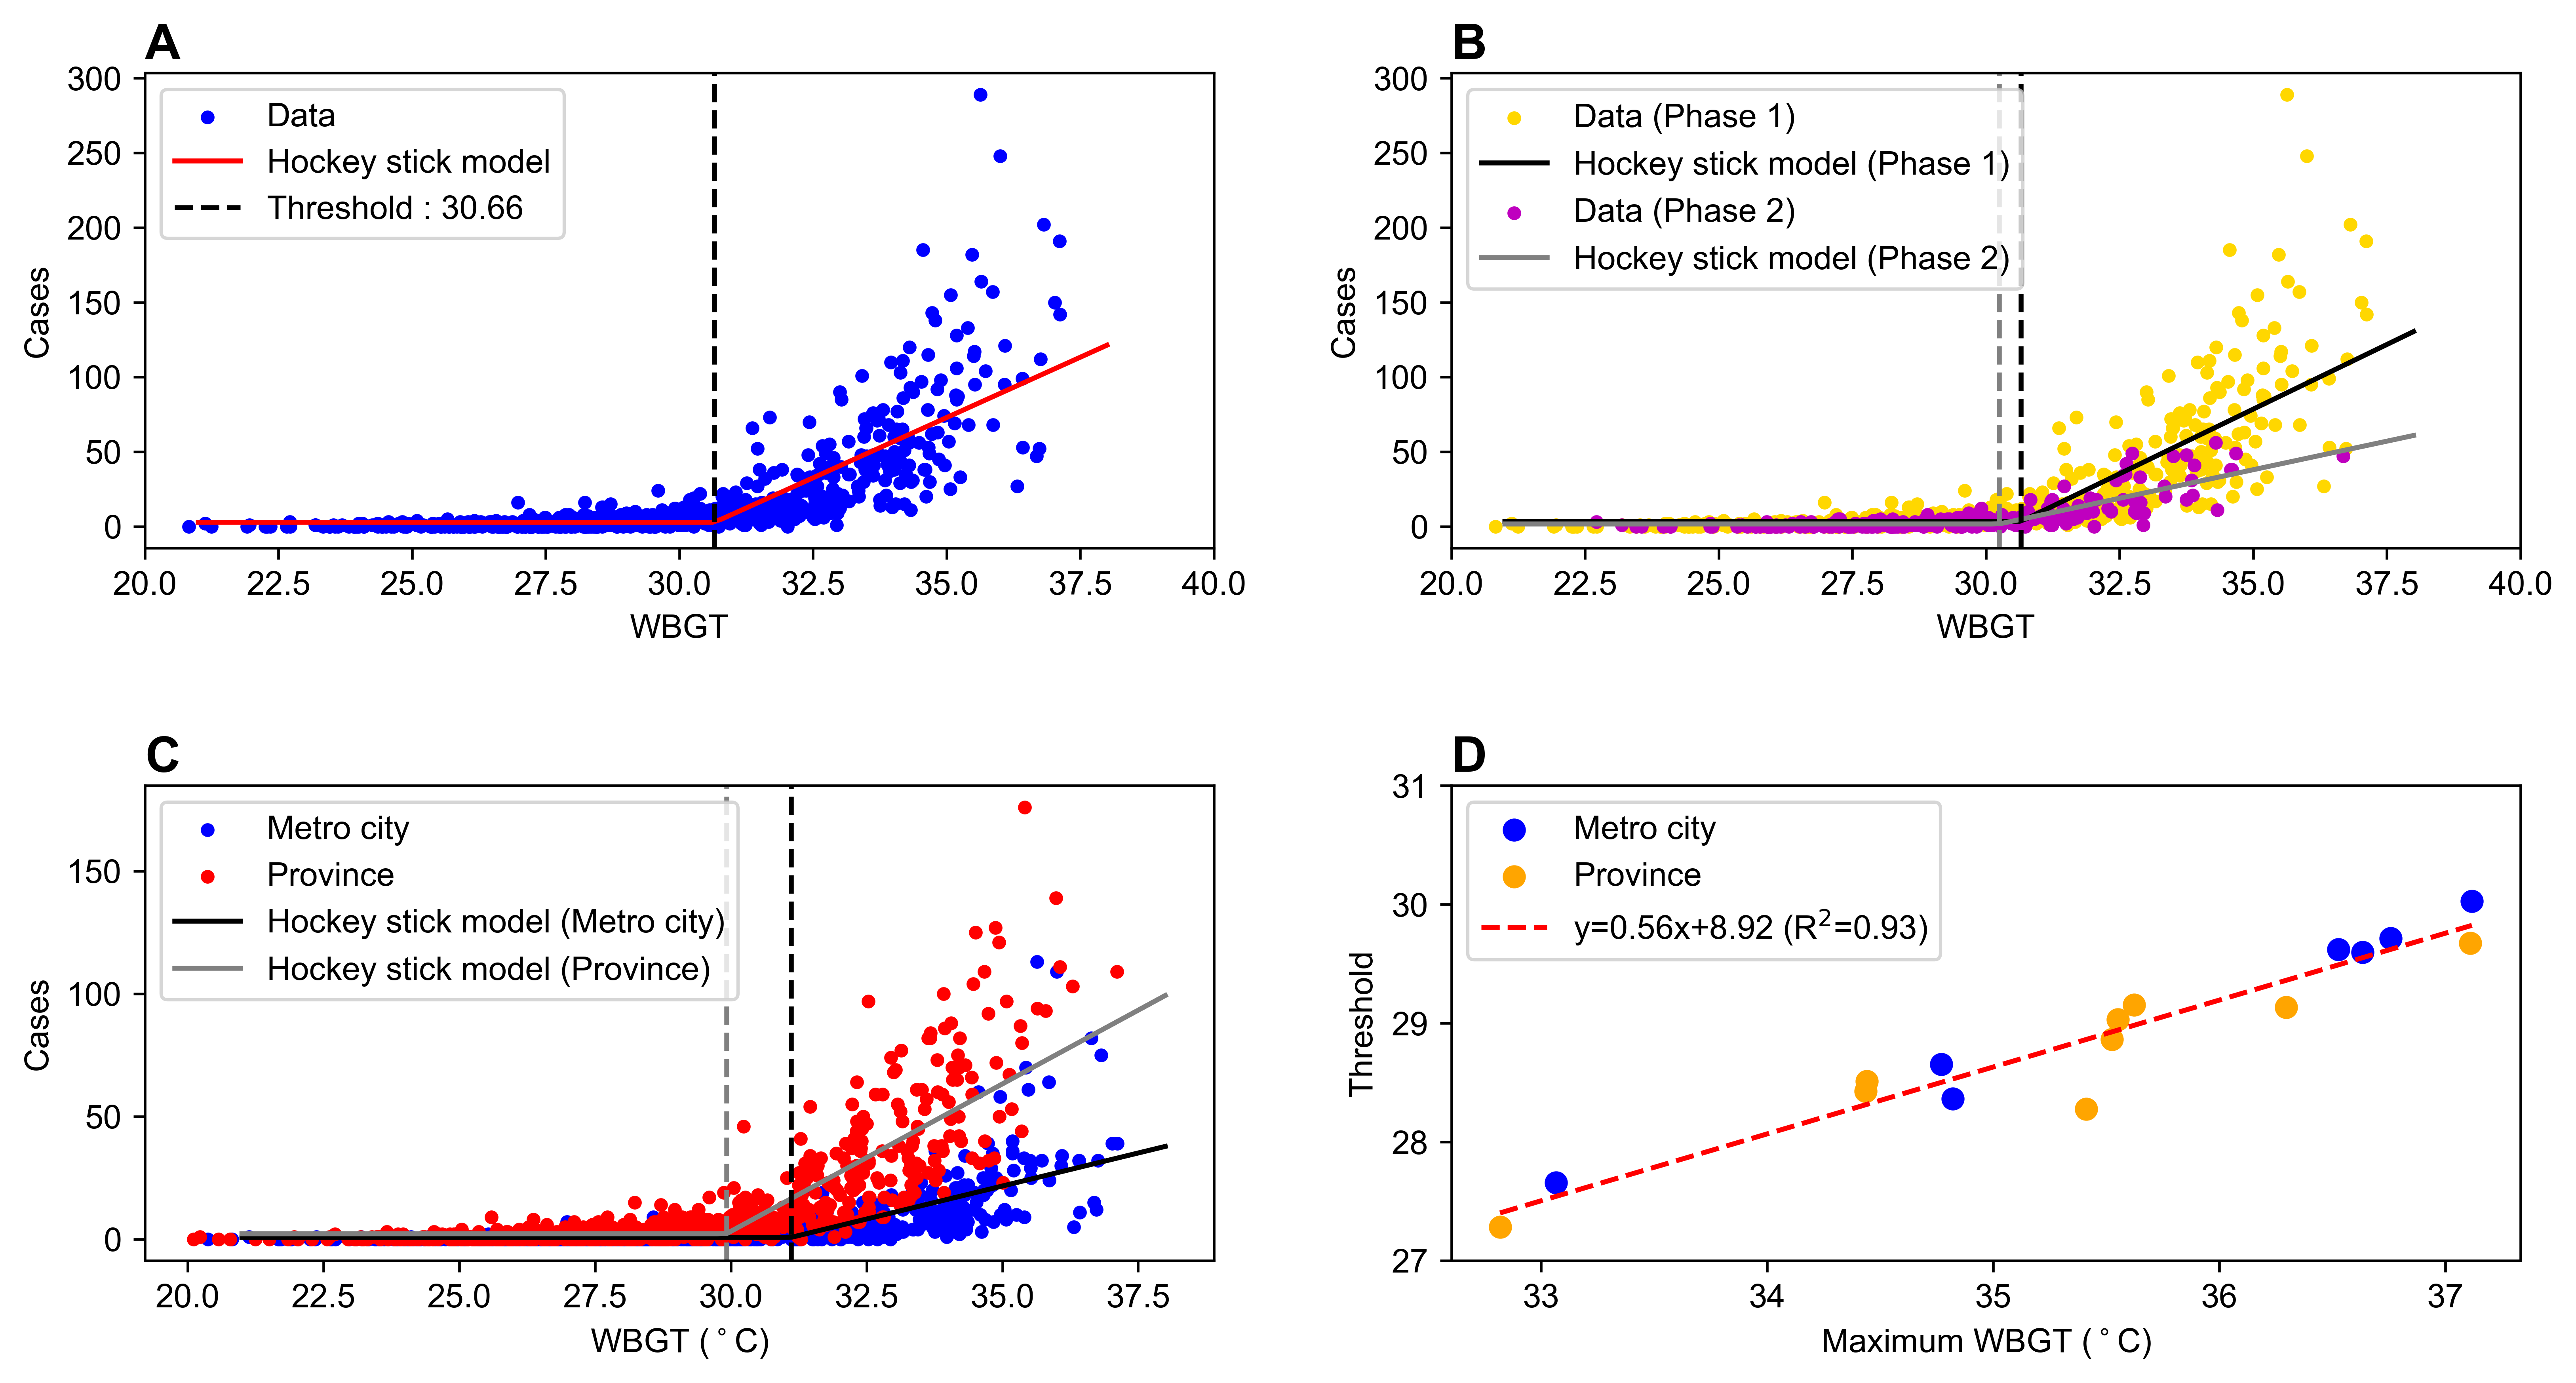

In [36]:
date_format = mdates.DateFormatter('%m-%d')
colors = cm.get_cmap('Reds', 10)

fig=plt.figure(figsize=(10, 5),dpi=600)

ax=[0]*4
gs=[0]*4

gs[0]=fig.add_gridspec(nrows=1,ncols=1,top=1, bottom=0.6,left=0, right=0.45)
gs[1]=fig.add_gridspec(nrows=1,ncols=1,top=1, bottom=0.6,left=0.55, right=1)
gs[2]=fig.add_gridspec(nrows=1,ncols=1,top=0.4, bottom=0,left=0, right=0.45)
gs[3]=fig.add_gridspec(nrows=1,ncols=1,top=0.4, bottom=0,left=0.55, right=1)

# tmp=data_loc1

i=0
ax[i]=fig.add_subplot(gs[i][0])
ax[i].scatter(data_loc2_drop['wbgt'],data_loc2_drop['case'],color='blue',s=10, label='Data')
ax[i].plot(x_fit,y_fit,color='red',label='Hockey stick model')
ax[i].axvline(x=t0, color='black', linestyle='--',label=f'Threshold : {t0:.2f}')
ax[i].set_xlabel('WBGT')
ax[i].set_ylabel('Cases')
ax[i].set_xlim(20,40)
ax[i].legend(ncols=1,loc='upper left')
ax[i].text(0,1.03,'{}'.format(string.ascii_uppercase[i]),transform=ax[i].transAxes,weight='bold',fontsize=15)

i=1
ax[i]=fig.add_subplot(gs[i][0])
tmp=data_loc2_drop.loc[data_loc2_drop['month2']<8.5]
# ax[i].scatter(tmp['wbgt'],tmp['case'],color='red',s=10,label='05.20. - 08.15.')
ax[i].scatter(tmp['wbgt'],tmp['case'],color='gold',s=10,label='Data (Phase 1)')
ax[i].plot(xp_fit,yp_fit,color='black',label=f'Hockey stick model (Phase 1)')
tmp=data_loc2_drop.loc[data_loc2_drop['month2']>=8.5]
# ax[i].scatter(tmp['wbgt'],tmp['case'],color='green',s=10,label='08.16. - 09.30.')
ax[i].scatter(tmp['wbgt'],tmp['case'],color='m',s=10,label='Data (Phase 2)')
ax[i].plot(xa_fit,ya_fit,color='gray',label=f'Hockey stick model (Phase 2)')
ax[i].set_xlim(20,40)
ax[i].axvline(x=t0_p, color='black', linestyle='--')
ax[i].axvline(x=t0_a, color='gray', linestyle='--')

ax[i].set_xlabel('WBGT')
ax[i].set_ylabel('Cases')
ax[i].legend(ncols=1,loc='upper left')
ax[i].text(0,1.03,'{}'.format(string.ascii_uppercase[i]),transform=ax[i].transAxes,weight='bold',fontsize=15)


i=2
ax[i]=fig.add_subplot(gs[i][0])
ax[i].scatter(metro_data_drop['wbgt'],metro_data_drop['case'],color='blue',s=10,label='Metro city')
ax[i].scatter(urban_data_drop['wbgt'],urban_data_drop['case'],color='red',s=10,label='Province')

ax[i].plot(x_fit,ym_fit_list[0],color='black',label=f'Hockey stick model (Metro city)')
ax[i].plot(x_fit,ym_fit_list[1],color='gray',label=f'Hockey stick model (Province)')

ax[i].axvline(x=resultm_list[0][0], color='black', linestyle='--')
ax[i].axvline(x=resultm_list[1][0], color='gray', linestyle='--')

ax[i].set_xlabel(r'WBGT ($^\circ$C)')
ax[i].set_ylabel('Cases')
ax[i].legend()
ax[i].text(0,1.03,'{}'.format(string.ascii_uppercase[i]),transform=ax[i].transAxes,weight='bold',fontsize=15)


i=3
ax[i]=fig.add_subplot(gs[i][0])
tmp=compare_df[compare_df['metro']==1]
ax[i].scatter(tmp['max'], tmp['t0'],color='blue',label='Metro city')

tmp=compare_df[compare_df['metro']==0]
ax[i].scatter(tmp['max'], tmp['t0'],color='orange',label='Province')


tmp1,tmp2=compare_df['max'].values[:],compare_df['t0'].values[:]
fit_ab, covar=curve_fit(func, tmp1, tmp2)
sigma_ab = np.sqrt(np.diagonal(covar))
xl_fit=np.linspace(tmp1.min(),tmp1.max(),100)
yx_fit=func(xl_fit,*(fit_ab))
yu_fit=func(xl_fit,*(fit_ab+sigma_ab))
yl_fit=func(xl_fit,*(fit_ab-sigma_ab))

pre_y=func(tmp1,*(fit_ab))
sst=np.sum((tmp2-tmp2.mean())**2)
ssr=np.sum((pre_y-tmp2.mean())**2)
r2=ssr/sst

ax[i].plot(xl_fit,yx_fit,linestyle='--',color='red',label=f'y={fit_ab[0]:.2f}x+{fit_ab[1]:.2f} (R$^2$={r2:.2f})')
ax[i].set_ylim(27,31)
ax[i].set_xlabel(r'Maximum WBGT ($^\circ$C)')
ax[i].set_ylabel('Threshold')
ax[i].legend()
ax[i].text(0,1.03,'{}'.format(string.ascii_uppercase[i]),transform=ax[i].transAxes,weight='bold',fontsize=15)

# fig.savefig(savefolder+'/FigS1.tiff', format='tiff', bbox_inches='tight', pad_inches=.1, dpi=set_dpi)
fig.savefig(savefolder+'/Fig5.jpg', format='jpg', bbox_inches='tight', pad_inches=.1, dpi=set_dpi)
plt.show()

In [37]:
compare_df.to_excel('./result/hockey_stick_region2023.xlsx',index=True)

### Region

In [38]:
x_fit=np.linspace(21,38,100)

In [39]:
#region_cap_name=['Seoul','Busan','Daegu','Incheon','Gwangju','Daejeon','Ulsan','Gyeonggi','Gangwon','Chungbuk','Chungnam','Jeonbuk','Jeonnam','Gyeongbuk','Gyeongnam','Jeju']
region_cap_name=['Seoul', 'Gyeonggi', 'Incheon', 'Chungbuk', 'Chungnam', 'Daejeon', 'Jeonbuk', 'Jeonnam', 'Gwangju', 'Jeju', 'Gangwon', 'Gyeongbuk', 'Daegu', 'Gyeongnam', 'Ulsan', 'Busan']
Region_code=['G1','G2','G3','G4','G5','G6','G7','G8','G9','G10', 'G11','G12','G13','G14','G15','G16']

In [40]:
result_region_list=[]
y_fit_region_list=[]

data_region_drop=data_region.dropna()
data_region_drop.reset_index(drop=True, inplace=True)

for x in region_cap_name:
    tmp=data_region_drop[data_region_drop['region']==x]
    minimizer_kwargs={"method":"SLSQP",
        # "method":"Nelder-Mead",
        "bounds":((tmp['wbgt'].min(),tmp['wbgt'].max()),(0,None),(0,None)),
        "args":(tmp['wbgt'],tmp['case'])}
    
    result_region = basinhopping(log_likelihood, initial_params, minimizer_kwargs=minimizer_kwargs, niter=1000,niter_success=100)
    th1,b1,b2=result_region.x
    
    x_fit=np.linspace(21,38,100)
    y_fit_region=hockey_stick(x_fit,th1,b1,b2)
    y_fit_region_list.append(y_fit_region)
    result_region_list.append(result_region.x)
    
    print(x,result_region.x)

Seoul [29.59619658  0.24736847  2.58328438]
Gyeonggi [29.6760676   0.73636366  4.91171498]
Incheon [27.65807276  0.15360684  1.55694297]
Chungbuk [29.15373909  0.13407822  1.0413591 ]
Chungnam [29.03235221  0.2035225   1.4510032 ]
Daejeon [29.71588593  0.04715127  0.30780752]
Jeonbuk [28.86331069  0.15106945  1.05447182]
Jeonnam [28.50969159  0.31262953  1.52060293]
Gwangju [30.02642721  0.07407505  0.42182049]
Jeju [27.28498278  0.08703665  0.44373639]
Gangwon [28.42734627  0.17275886  0.99266089]
Gyeongbuk [28.27781918  0.26096041  1.30224772]
Daegu [29.61968123  0.04821748  0.37230329]
Gyeongnam [29.13312777  0.25581403  1.59706236]
Ulsan [28.36466117  0.05846765  0.37205982]
Busan [28.6539892   0.10299624  1.2333656 ]


In [41]:
fig, ax = plt.subplots(8, 2, figsize=(11, 23), dpi=600)
plt.subplots_adjust(hspace=0.4, wspace=0.3)

for j in range(16):
    row = j // 2
    col = j % 2
    
    x = region_cap_name[j]
    region_code=Region_code[j]
    tmp = data_region_drop[data_region_drop['region'] == x]
    
    ax[row][col].scatter(tmp['wbgt'], tmp['case'], color='blue', s=10, label='Data')
    ax[row][col].plot(x_fit, y_fit_region_list[j], color='red')
    ax[row][col].axvline(x=result_region_list[j][0], color='black', linestyle='--')
    
    ax[row][col].set_title(f'{region_cap_name[j]} ({region_code})', weight='bold')
    ax[row][col].margins(0)
    ax[row][col].set_ylim(0, round(tmp['case'].max() * 1.2))
    ax[row][col].set_xlim(15, 40)
    if (row != 7) & (row != 3):
        ax[row][col].set_xticks([])
    ax[row][col].set_ylabel('Cases', fontsize=12)
    ax[row][col].text(0, 1.03, '{}'.format(string.ascii_uppercase[j]), transform=ax[row][col].transAxes, weight='bold', fontsize=15)

ax[0][0].legend(loc='upper left', fontsize=13)
ax[4][0].legend(loc='upper left', fontsize=13)

ax[3][0].set_xlabel(r'WBGT ($^\circ$C)', fontsize=12)
ax[3][1].set_xlabel(r'WBGT ($^\circ$C)', fontsize=12)

ax[7][0].set_xlabel(r'WBGT ($^\circ$C)', fontsize=12)
ax[7][1].set_xlabel(r'WBGT ($^\circ$C)', fontsize=12)

plt.show()

fig.savefig(savefolder+'/Figure S5.jpg', format='jpg', bbox_inches='tight', pad_inches=.1, dpi=set_dpi)

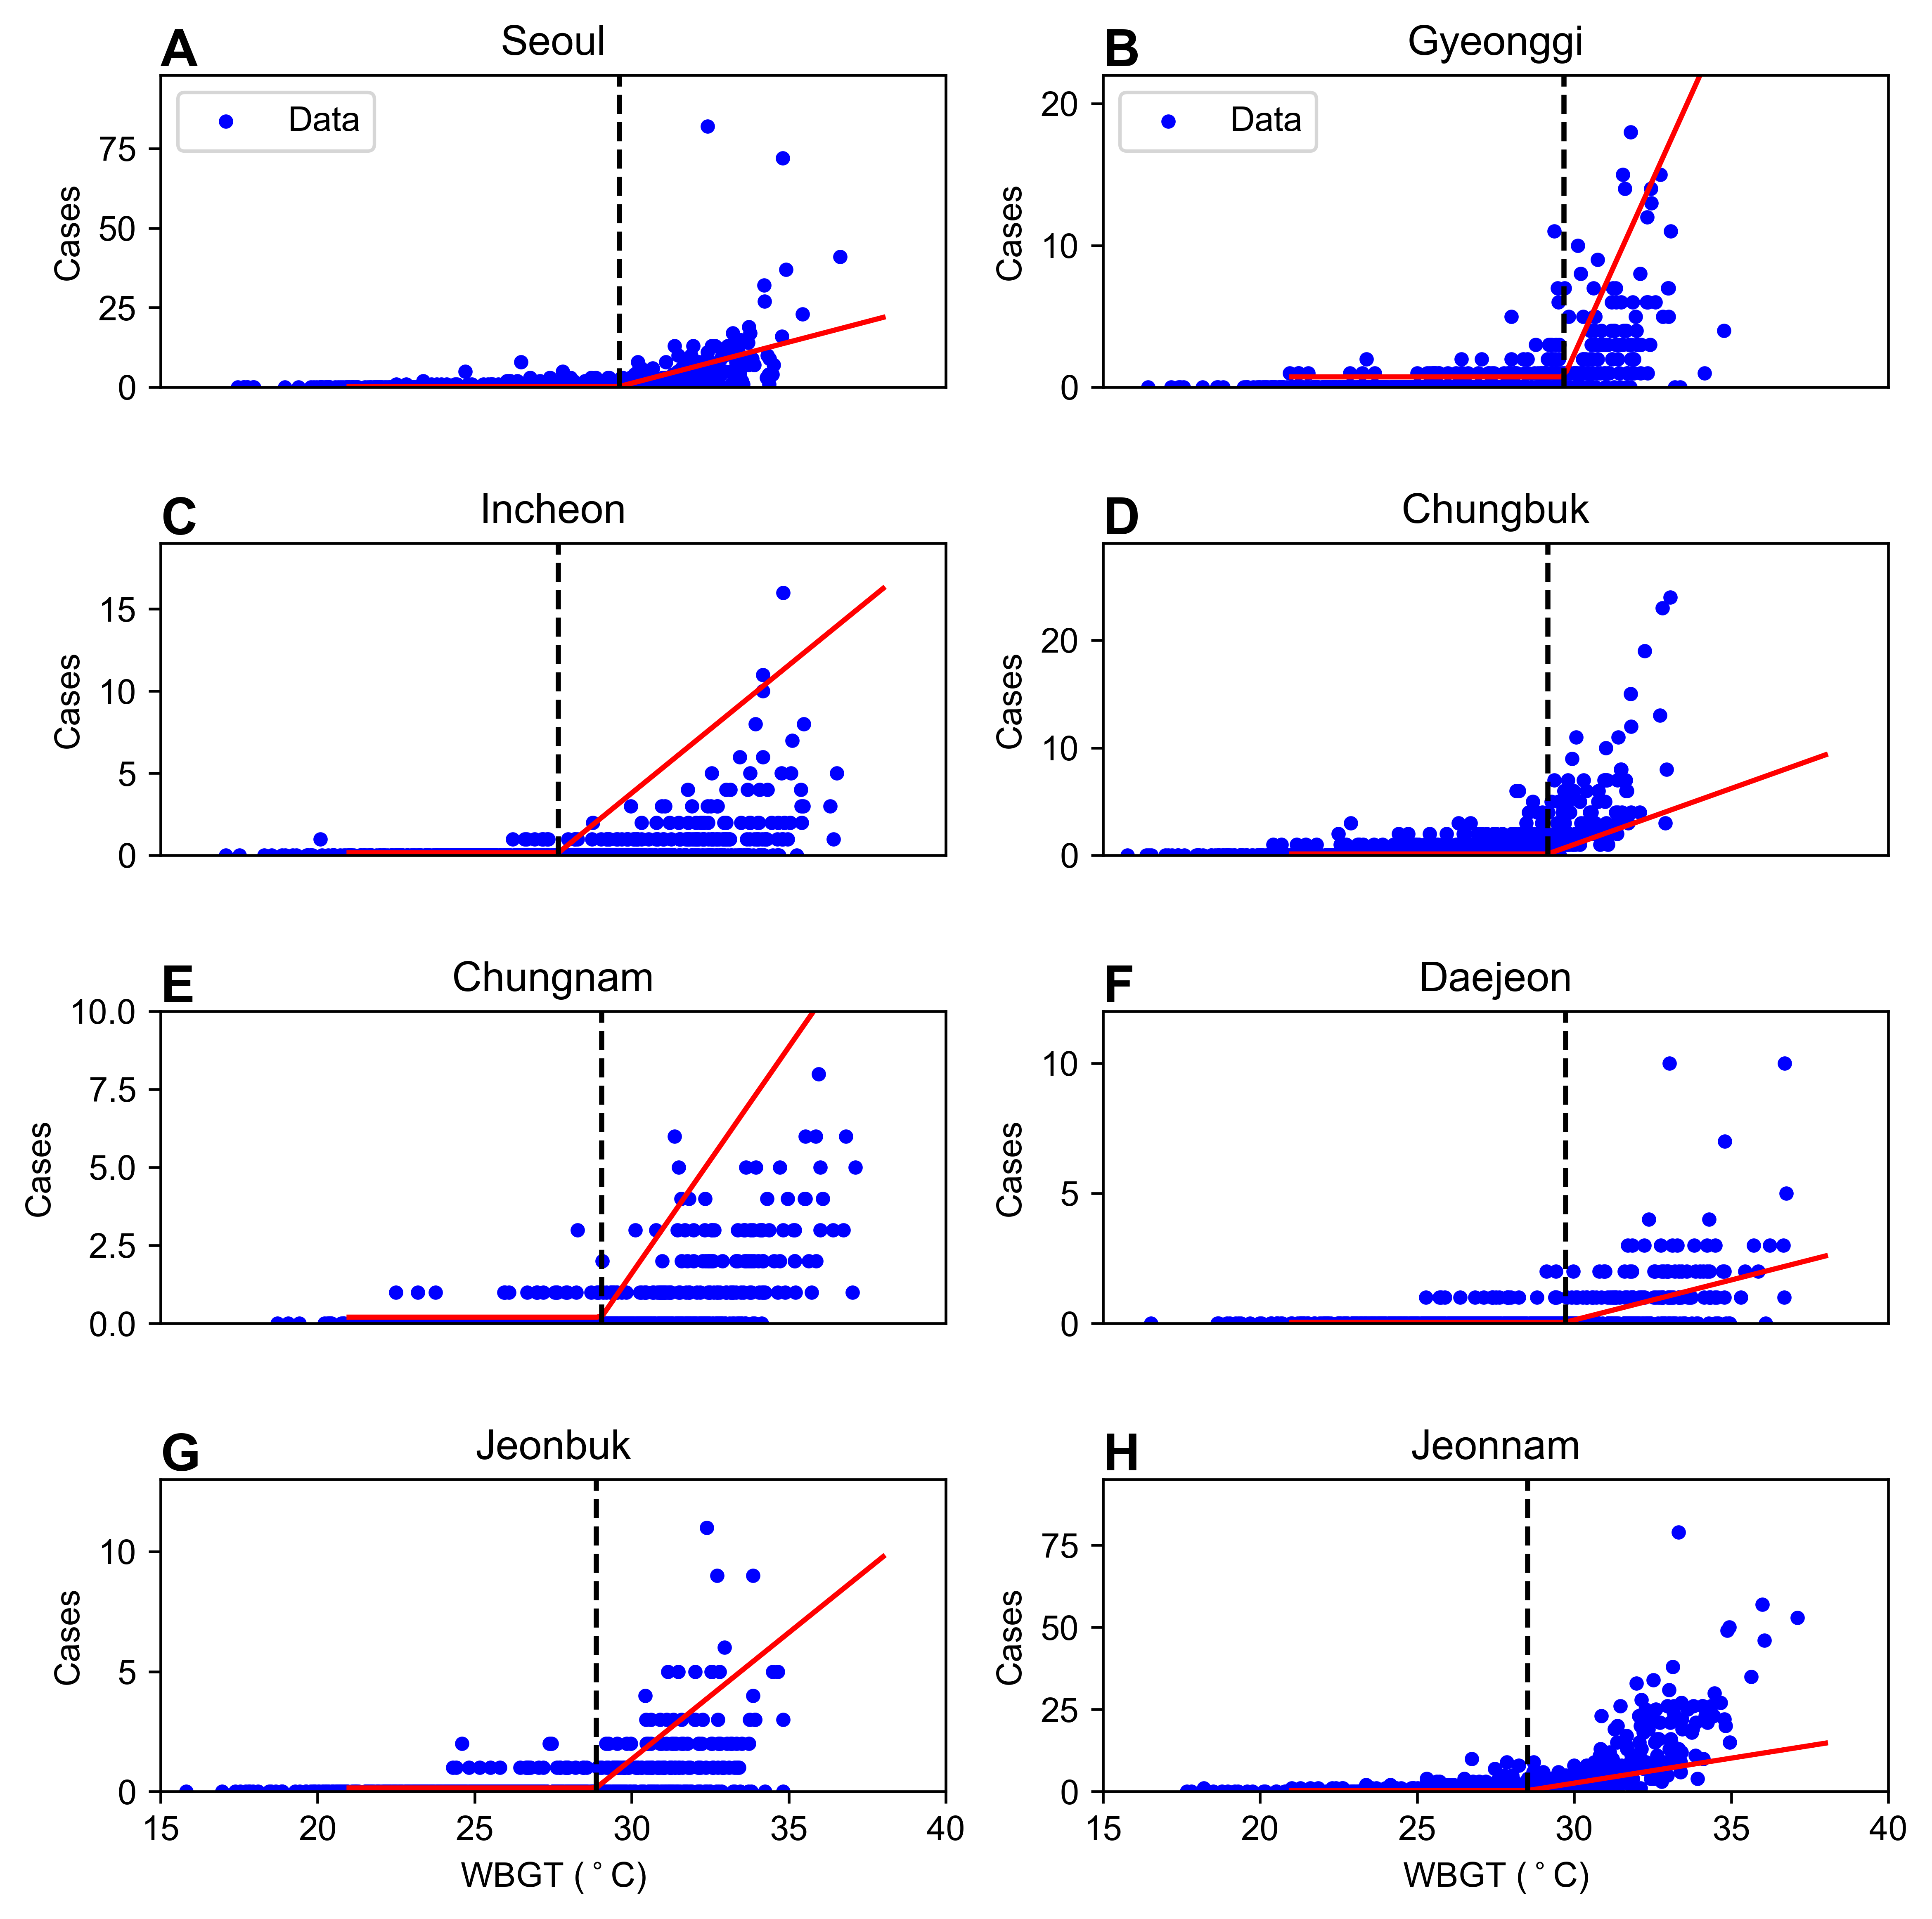

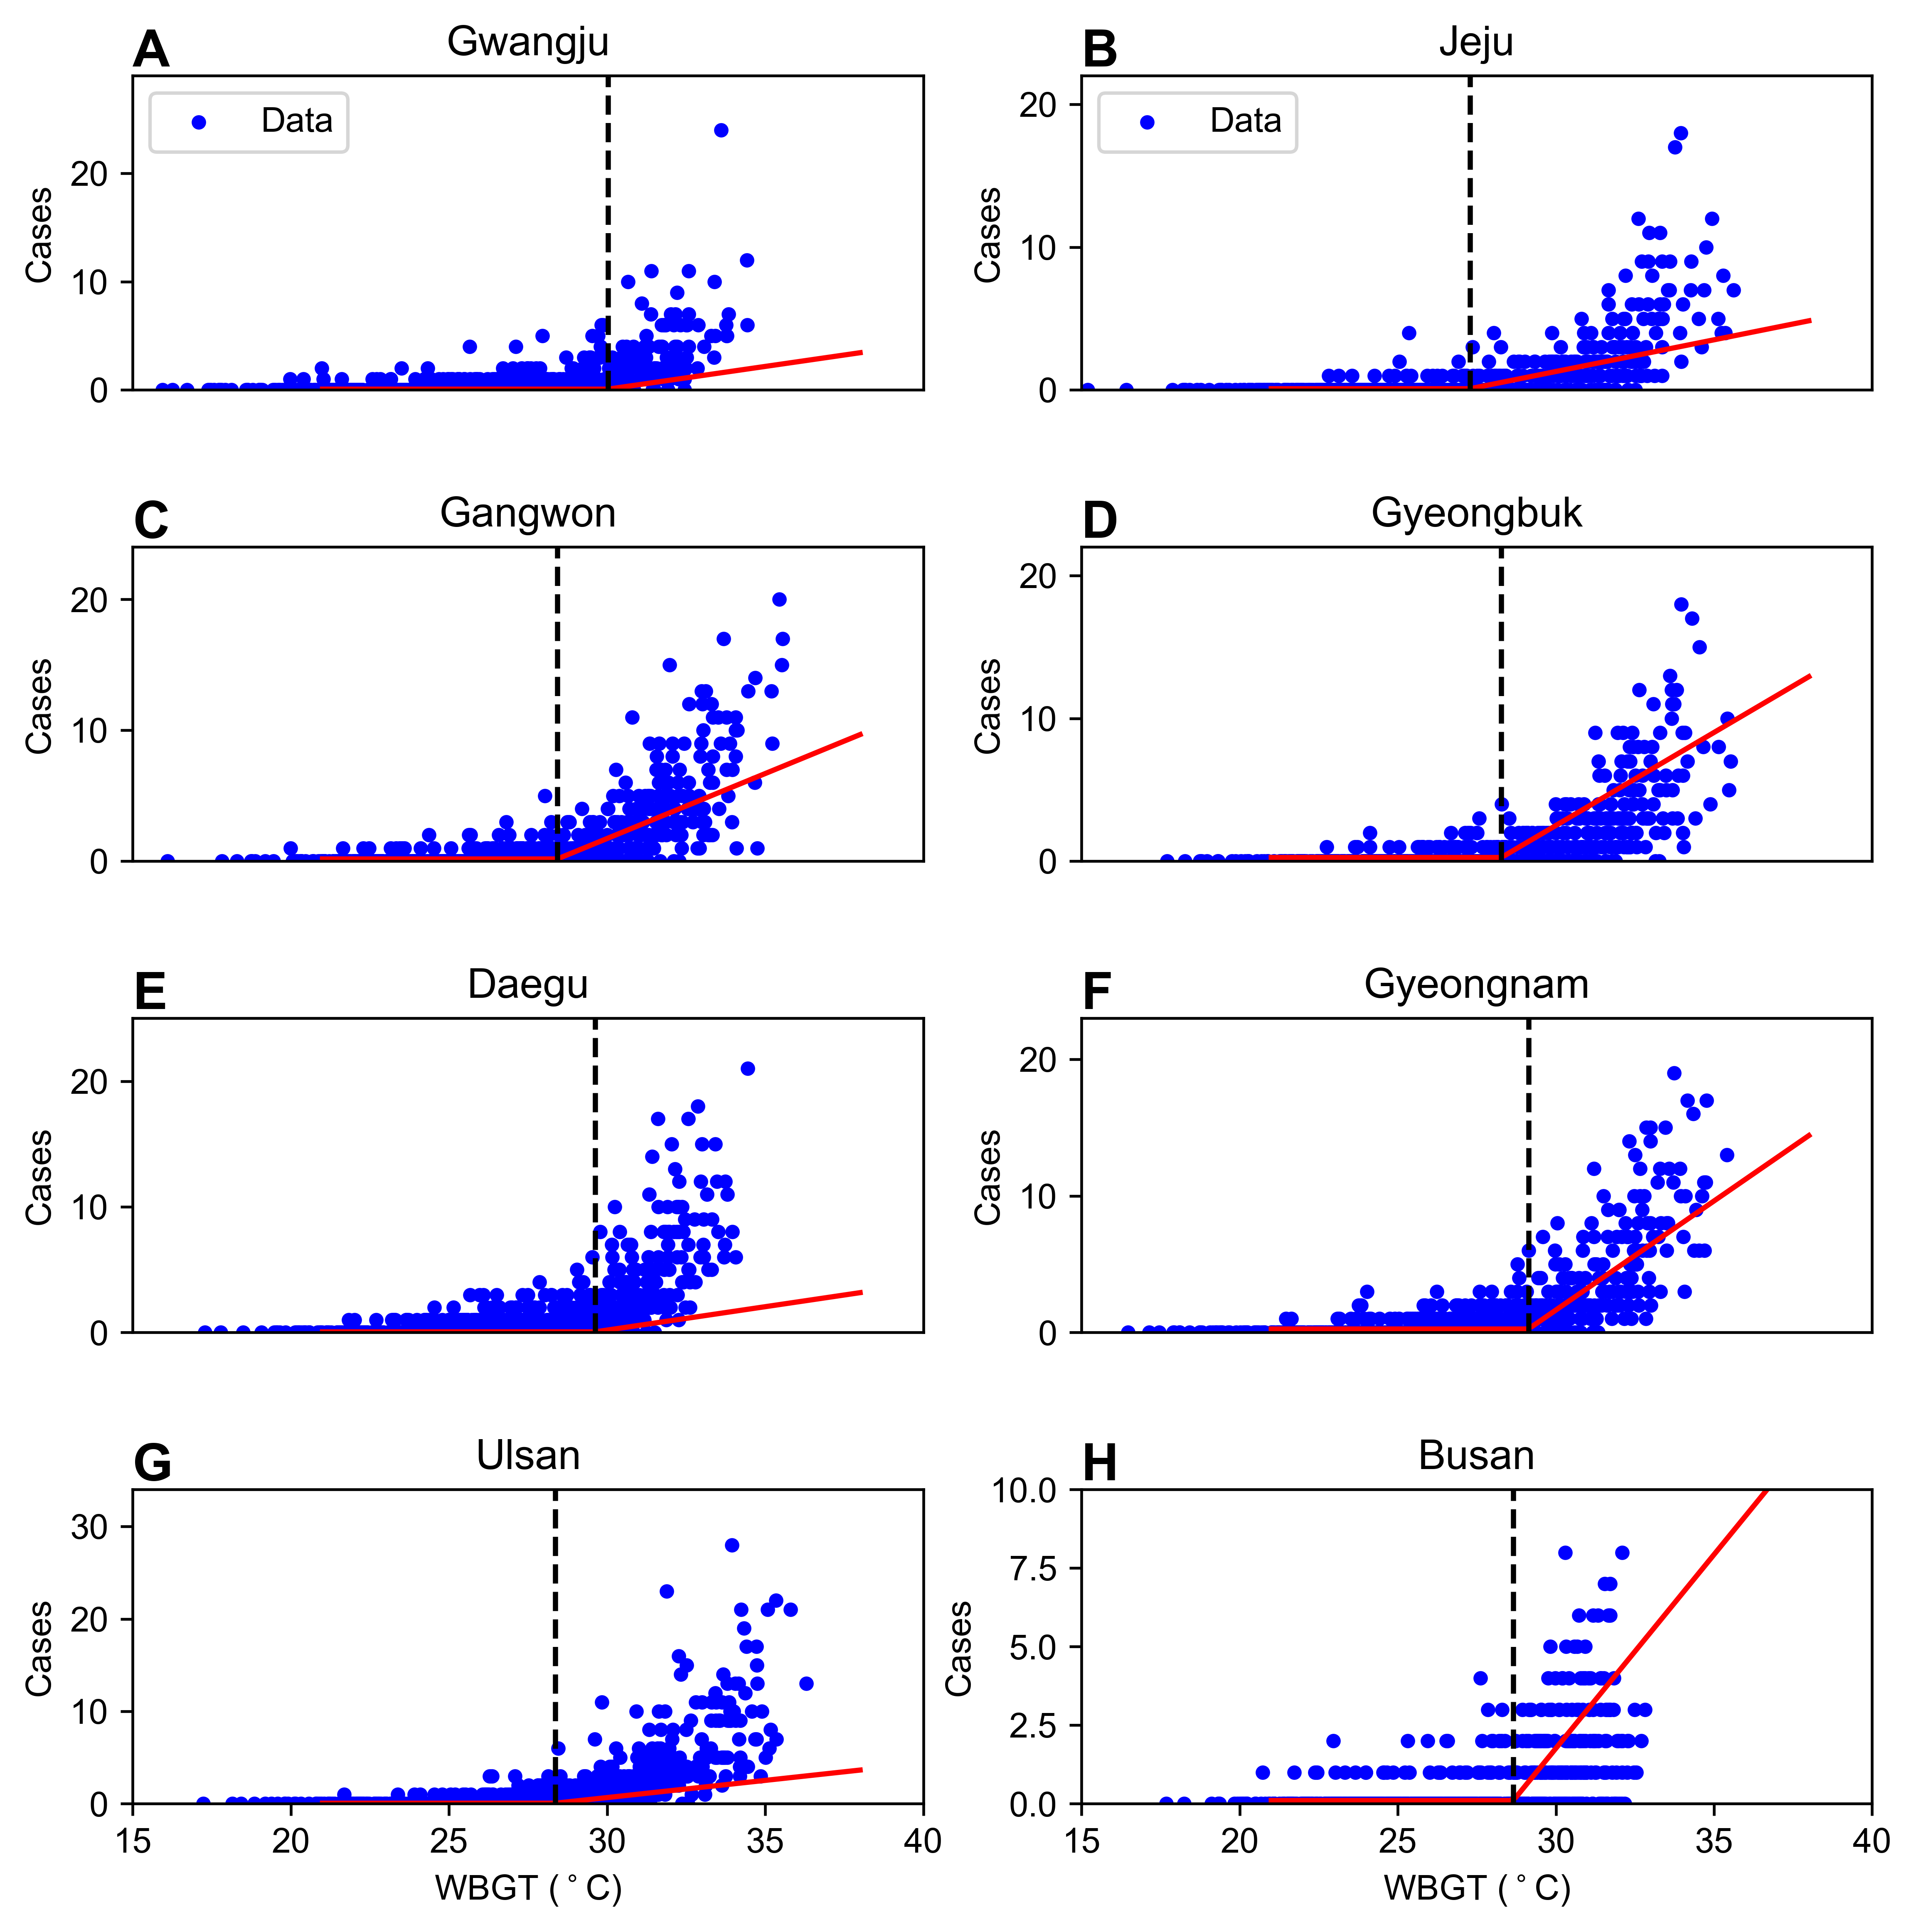

In [42]:
for k in range(2):
    fig,ax=plt.subplots(4,2,figsize=(9, 9),dpi=600)
    plt.subplots_adjust(hspace=0.5)
    # plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3, hspace=0.5)
    for i in range(8):
        j=i+k*8
        
        x=region_name[j]
        tmp=data_region_drop[(data_region_drop['region']==x)]
        
        ax[i//2][i%2].scatter(tmp['wbgt'],tmp['case'],color='blue',s=10, label='Data')
        ax[i//2][i%2].plot(x_fit,y_fit_region_list[j],color='red')
        ax[i//2][i%2].axvline(x=result_region_list[j][0], color='black', linestyle='--')

        ax[i//2][i%2].set_title(region_cap_name[j])
        ax[i//2][i%2].margins(0)
        # ax[i//2][i%2].set_ylim(0,100)
        ax[i//2][i%2].set_ylim(0,round(tmp['case'].max()*1.2))
        ax[i//2][i%2].set_xlim(15,40)
        if i<6:
            ax[i//2][i%2].set_xticks([])
        # ax[i].set_xticks([result_p_list[j][0],result_a_list[j][0]])
        ax[i//2][i%2].set_ylabel('Cases')
        ax[i//2][i%2].text(0,1.03,'{}'.format(string.ascii_uppercase[i]),transform=ax[i//2][i%2].transAxes,weight='bold',fontsize=15)
        
    ax[0][0].legend(loc='upper left')
    ax[0][1].legend(loc='upper left')
        
    ax[3][0].set_xlabel(r'WBGT ($^\circ$C)')
    ax[3][1].set_xlabel(r'WBGT ($^\circ$C)')
    plt.show()


### forecasting

In [43]:
data126=pd.read_csv('./data/Final_SSP126_data.csv')
data245=pd.read_csv('./data/Final_SSP245_data.csv')
data370=pd.read_csv('./data/Final_SSP370_data.csv')
data585=pd.read_csv('./data/Final_SSP585_data.csv')

In [44]:
data126['date']=pd.to_datetime(data126['date'])
data245['date']=pd.to_datetime(data245['date'])
data370['date']=pd.to_datetime(data370['date'])
data585['date']=pd.to_datetime(data585['date'])

In [45]:
data126

date region  tmax  tavg  rhum         Tw       wbgt  weight_wbgt  \
0      2024-05-20  Seoul  30.1  23.8  50.9  22.541241  26.717826    60.478899   
1      2024-05-21  Seoul  29.3  22.8  58.3  23.090105  26.597087    62.562437   
2      2024-05-22  Seoul  24.8  20.0  74.9  21.434827  23.390169    60.698534   
3      2024-05-23  Seoul  27.9  22.1  70.6  23.729231  26.207540    60.877927   
4      2024-05-24  Seoul  26.8  21.6  81.3  24.242411  25.902462    60.902595   
...           ...    ...   ...   ...   ...        ...        ...          ...   
111617 2072-09-26   Jeju  29.0  25.2  73.6  25.211946  27.562290    64.155401   
111618 2072-09-27   Jeju  29.2  25.6  76.9  25.898438  28.026223    65.858579   
111619 2072-09-28   Jeju  28.6  25.6  82.0  26.079236  27.803675    66.762028   
111620 2072-09-29   Jeju  26.0  21.1  67.3  21.478728  24.031444    63.090119   
111621 2072-09-30   Jeju  22.2  19.3  61.2  17.150078  19.776901    55.684261   

        COVID19  year  ...  agri_area1  agri_area2           pop  \
0             0  2024  ...       200.0       407.0  9.393699e+06   
1             0  2024  ...       200.0       407.0  9.393699e+06   
2             0  2024  ...       200.0       407.0  9.393699e+06   
3             0  2024  ...       200.0       407.0  9.393699e+06   
4             0  2024  ...       200.0       407.0  9.393699e+06   
...         ...   ...  ...         ...         ...           ...   
111617        0  2072  ...        12.0     55593.0  5.034877e+05   
111618        0  2072  ...        12.0     55593.0  5.034877e+05   
111619        0  2072  ...        12.0     55593.0  5.034877e+05   
111620        0  2072  ...        12.0     55593.0  5.034877e+05   
111621        0  2072  ...        12.0     55593.0  5.034877e+05   

                 60+   sex_rate  phase  elder_rate      agri_pop  \
0       2.480790e+06  92.763306    0.0    8.273993  13646.892198   
1       2.480790e+06  92.763306    0.0    8.273993  13646.892198   
2       2.480790e+06  92.763306    0.0    8.273993  13646.892198   
3       2.480790e+06  92.763306    0.0    8.273993  13646.892198   
4       2.480790e+06  92.763306    0.0    8.273993  13646.892198   
...              ...        ...    ...         ...           ...   
111617  2.775811e+05  97.606113    1.0   18.377626  54334.056948   
111618  2.775811e+05  97.606113    1.0   18.377626  54334.056948   
111619  2.775811e+05  97.606113    1.0   18.377626  54334.056948   
111620  2.775811e+05  97.606113    1.0   18.377626  54334.056948   
111621  2.775811e+05  97.606113    1.0   18.377626  54334.056948   

        simple_job_pop  pop_density  
0         1.045460e+06     0.015497  
1         1.045460e+06     0.015497  
2         1.045460e+06     0.015497  
3         1.045460e+06     0.015497  
4         1.045460e+06     0.015497  
...                ...          ...  
111617    8.784570e+04     0.001073  
111618    8.784570e+04     0.001073  
111619    8.784570e+04     0.001073  
111620    8.784570e+04     0.001073  
111621    8.784570e+04     0.001073  

[111622 rows x 26 columns]

In [46]:
lstm126=pd.read_csv('./result/LSTM_result_SSP126.csv')
lstm245=pd.read_csv('./result/LSTM_result_SSP245.csv')
lstm370=pd.read_csv('./result/LSTM_result_SSP370.csv')
lstm585=pd.read_csv('./result/LSTM_result_SSP585.csv')

In [47]:
df_126=pd.DataFrame([],columns=['date','case','wbgt'])
df_126['date']=data126.date.unique()
df_126['wbgt']=data126.groupby('date')['wbgt'].max().values
df_126=df_126[df_126['date'].dt.strftime('%m-%d')>'05-21']
df_126=df_126[df_126['date'].dt.year<=2070]
df_126.reset_index(drop=True, inplace=True)
df_126['case']=lstm126['Korea']
df_126['year']=df_126['date'].dt.year

In [48]:
df_245=pd.DataFrame([],columns=['date','case','wbgt'])
df_245['date']=data245.date.unique()
df_245['wbgt']=data245.groupby('date')['wbgt'].max().values
df_245=df_245[df_245['date'].dt.strftime('%m-%d')>'05-21']
df_245=df_245[df_245['date'].dt.year<=2070]
df_245.reset_index(drop=True, inplace=True)
df_245['case']=lstm245['Korea']
df_245['year']=df_245['date'].dt.year

In [49]:
df_370=pd.DataFrame([],columns=['date','case','wbgt'])
df_370['date']=data370.date.unique()
df_370['wbgt']=data370.groupby('date')['wbgt'].max().values
df_370=df_370[df_370['date'].dt.strftime('%m-%d')>'05-21']
df_370=df_370[df_370['date'].dt.year<=2070]
df_370.reset_index(drop=True, inplace=True)
df_370['case']=lstm370['Korea']
df_370['year']=df_370['date'].dt.year

In [50]:
df_585=pd.DataFrame([],columns=['date','case','wbgt'])
df_585['date']=data585.date.unique()
df_585['wbgt']=data585.groupby('date')['wbgt'].max().values
df_585=df_585[df_585['date'].dt.strftime('%m-%d')>'05-21']
df_585=df_585[df_585['date'].dt.year<=2070]
df_585.reset_index(drop=True, inplace=True)
df_585['case']=lstm585['Korea']
df_585['year']=df_585['date'].dt.year

In [51]:
df_126=pd.concat([data_loc2_drop[['date','case','wbgt','year']],df_126])
df_126.reset_index(drop=True, inplace=True)

In [52]:
df_585=pd.concat([data_loc2_drop[['date','case','wbgt','year']],df_585])
df_585.reset_index(drop=True, inplace=True)

In [53]:
# df_126['period']=0
# df_126.loc[df_126['year']>2030,'period']=1
# df_126.loc[df_126['year']>2040,'period']=2
# df_126.loc[df_126['year']>2050,'period']=3
# df_126.loc[df_126['year']>2060,'period']=4

In [54]:
# ssp_126_result=[]
# ssp_126_fit=[]

# for i in range(len(df_126['period'].unique())):
#         tmp=df_126[df_126['period']==i]

#         minimizer_kwargs={"method":"SLSQP",
#         # "method":"Nelder-Mead",

#         "bounds":((tmp['wbgt'].min(),tmp['wbgt'].max()),(0,None),(0,None)),
#         "args":(tmp['wbgt'], round(tmp['case']))}

#         result_126 = basinhopping(log_likelihood, initial_params, minimizer_kwargs=minimizer_kwargs, niter=1000,niter_success=100)

#         t0_ssp126,b1_ssp126,b2_ssp126=result_126.x
#         x_fit_126=np.linspace(21,40,100)
#         y_fit_126=hockey_stick(x_fit_126,t0_ssp126,b1_ssp126,b2_ssp126)
#         ssp_126_result.append(result_126.x)
#         ssp_126_fit.append(y_fit_126)

In [55]:
df_585['period']=-1
df_585.loc[df_585['year']<2024,'period']=0
df_585.loc[df_585['year']>2030,'period']=1
df_585.loc[df_585['year']>2040,'period']=2
df_585.loc[df_585['year']>2050,'period']=3
df_585.loc[df_585['year']>2060,'period']=4

In [56]:
ssp_585_result=[]
ssp_585_fit=[]

for i in range(0,5):
        tmp=df_585[df_585['period']==i]

        minimizer_kwargs={"method":"SLSQP",
        # "method":"Nelder-Mead",

        "bounds":((tmp['wbgt'].min(),tmp['wbgt'].max()),(0,None),(0,None)),
        "args":(tmp['wbgt'], round(tmp['case']))}

        result_585 = basinhopping(log_likelihood, initial_params, minimizer_kwargs=minimizer_kwargs, niter=1000,niter_success=100)

        t0_ssp585,b1_ssp585,b2_ssp585=result_585.x
        x_fit_585=np.linspace(21,40,100)
        y_fit_585=hockey_stick(x_fit_585,t0_ssp585,b1_ssp585,b2_ssp585)
        ssp_585_result.append(result_585.x)
        ssp_585_fit.append(y_fit_585)

ssp_585_result

[array([30.65646323,  2.79249431, 16.14122548]),
 array([31.05315098,  6.6299566 , 28.5002073 ]),
 array([31.57497743,  7.4642851 , 34.652757  ]),
 array([31.96208011,  8.85521881, 39.40589924]),
 array([32.37727833,  9.26441253, 39.18586395])]

In [57]:
base_result

array([30.65646322,  2.79249467, 16.14122597])

In [58]:
# colors=['blue','green','orange','red']
# years=['2024-2039','2040-2055','2056-2072']

In [59]:
# date_format = mdates.DateFormatter('%m-%d')

# gs=[0]*4
# ax=[0]*4

# fig=plt.figure(figsize=(10, 8),dpi=600)

# gs[0]=fig.add_gridspec(nrows=1,ncols=1,top=1, bottom=0.75,left=0, right=0.45)
# gs[1]=fig.add_gridspec(nrows=1,ncols=1,top=1, bottom=0.75,left=0.55, right=1)
# gs[2]=fig.add_gridspec(nrows=1,ncols=1,top=0.65, bottom=0.4,left=0, right=0.45)
# gs[3]=fig.add_gridspec(nrows=1,ncols=1,top=0.65, bottom=0.4,left=0.55, right=1)



# i=0
# ax[i]=fig.add_subplot(gs[i][0])
# ax[i].scatter(metro_data_drop['wbgt'],metro_data_drop['case'],color='blue',s=10,label='Metro city', alpha=0.5)
# ax[i].scatter(urban_data_drop['wbgt'],urban_data_drop['case'],color='orange',s=10,label='Province', alpha=0.5)

# ax[i].plot(x_fit,ym_fit_list[0],color='black',label=f'Hockey stick model (Metro city)')
# ax[i].plot(x_fit,ym_fit_list[1],color='gray',label=f'Hockey stick model (Province)')

# # ax[i].axvline(x=resultm_list[0][0], color='black', linestyle='--')
# # ax[i].axvline(x=resultm_list[1][0], color='gray', linestyle='--')

# ax[i].set_xlabel(r'WBGT ($^\circ$C)')
# ax[i].set_ylabel('Cases')
# ax[i].legend()
# ax[i].text(0,1.03,'{}'.format(string.ascii_uppercase[i]),transform=ax[i].transAxes,weight='bold',fontsize=15)


# i=1
# ax[i]=fig.add_subplot(gs[i][0])
# tmp=compare_df[compare_df['metro']==1]
# ax[i].scatter(tmp['max'], tmp['t0'],color='blue',label='Metro city')

# tmp=compare_df[compare_df['metro']==0]
# ax[i].scatter(tmp['max'], tmp['t0'],color='orange',label='Province')


# tmp1,tmp2=compare_df['max'].values[:],compare_df['t0'].values[:]
# fit_ab, covar=curve_fit(func, tmp1, tmp2)
# sigma_ab = np.sqrt(np.diagonal(covar))
# xl_fit=np.linspace(tmp1.min(),tmp1.max(),100)
# yx_fit=func(xl_fit,*(fit_ab))
# yu_fit=func(xl_fit,*(fit_ab+sigma_ab))
# yl_fit=func(xl_fit,*(fit_ab-sigma_ab))

# pre_y=func(tmp1,*(fit_ab))
# sst=np.sum((tmp2-tmp2.mean())**2)
# ssr=np.sum((pre_y-tmp2.mean())**2)
# r2=ssr/sst

# ax[i].plot(xl_fit,yx_fit,linestyle='--',color='red',label=f'y={fit_ab[0]:.2f}x+{fit_ab[1]:.2f} (R$^2$={r2:.2f})')
# ax[i].set_ylim(27,31)
# ax[i].set_xlabel(r'Maximum WBGT ($^\circ$C)')
# ax[i].set_ylabel('Threshold')
# ax[i].legend()
# ax[i].text(0,1.03,'{}'.format(string.ascii_uppercase[i]),transform=ax[i].transAxes,weight='bold',fontsize=15)


# i=2
# ax[i]=fig.add_subplot(gs[i][0])

# # colors=['gray','black','green','blue']
# # years=['','','2056-2072','2018-2023']



# j=3
# tmp_result=ssp_126_result
# tmp_fit=ssp_126_fit
# tmp_data=df_126[df_126['period']==j]

# # ax[i].scatter(df_126['wbgt'],df_126['case'],s=10, label='Data')
# ax[i].scatter(tmp_data['wbgt'],tmp_data['case'],color='red',s=10,label='2056-2072', alpha=0.5)

# # ax[i].axvline(x=tmp_result[j][0], color='gray', linestyle='--',label=f'Threshold : {tmp_result[j][0]:.2f}')

# j=0
# tmp_result=ssp_126_result
# tmp_fit=ssp_126_fit
# tmp_data=df_126[df_126['period']==j]

# # ax[i].scatter(df_126['wbgt'],df_126['case'],s=10, label='Data')
# ax[i].scatter(tmp_data['wbgt'],tmp_data['case'],color='green',s=10,label='2018-2023', alpha=0.5)


# ax[i].plot(x_fit_126,tmp_fit[3],color='black',label='Hockey stick model (2056-2072)')
# ax[i].plot(x_fit_126,tmp_fit[0],color='gray',label='Hockey stick model (2018-2023)')

# # ax[i].axvline(x=tmp_result[j][0], color='black', linestyle='--',label=f'Threshold : {tmp_result[j][0]:.2f}')


# ax[i].set_title('SSP1-2.6')
# ax[i].set_xlabel('WBGT')
# ax[i].set_ylabel('Cases')
# ax[i].set_xlim(20,42)
# ax[i].legend(ncols=1,loc='upper left')
# ax[i].text(0,1.03,'{}'.format(string.ascii_uppercase[i]),transform=ax[i].transAxes,weight='bold',fontsize=15)

# i=3
# ax[i]=fig.add_subplot(gs[i][0])

# colors=['gray','black','red','blue']
# years=['','','2056-2072','2018-2023']



# j=3
# tmp_result=ssp_585_result
# tmp_fit=ssp_585_fit
# tmp_data=df_585[df_585['period']==j]

# # ax[i].scatter(df_585['wbgt'],df_585['case'],s=10, label='Data')
# ax[i].scatter(tmp_data['wbgt'],tmp_data['case'],color='red',s=10,label='2056-2072', alpha=0.5)

# j=0
# tmp_result=ssp_585_result
# tmp_fit=ssp_585_fit
# tmp_data=df_585[df_585['period']==j]

# # ax[i].scatter(df_585['wbgt'],df_585['case'],s=10, label='Data')
# ax[i].scatter(tmp_data['wbgt'],tmp_data['case'],color='green',s=10,label='2018-2023', alpha=0.5)



# # ax[i].axvline(x=tmp_result[j][0], color='gray', linestyle='--',label=f'Threshold : {tmp_result[j][0]:.2f}')
# ax[i].plot(x_fit_585,tmp_fit[3],color='black',label='Hockey stick model (2056-2072)')
# ax[i].plot(x_fit_585,tmp_fit[0],color='gray',label='Hockey stick model (2018-2023)')

# # ax[i].axvline(x=tmp_result[j][0], color='black', linestyle='--',label=f'Threshold : {tmp_result[j][0]:.2f}')

    
# ax[i].set_title('SSP5-8.5')
# ax[i].set_xlabel('WBGT')
# ax[i].set_ylabel('Cases')
# ax[i].set_xlim(20,42)
# ax[i].legend(ncols=1,loc='upper left')
# ax[i].text(0,1.03,'{}'.format(string.ascii_uppercase[i]),transform=ax[i].transAxes,weight='bold',fontsize=15)



# # fig.savefig(savefolder+'/FigS1.tiff', format='tiff', bbox_inches='tight', pad_inches=.1, dpi=set_dpi)
# # fig.savefig(savefolder+'/Fig5.jpg', format='jpg', bbox_inches='tight', pad_inches=.1, dpi=set_dpi)
# plt.show()

In [60]:
# date_format = mdates.DateFormatter('%m-%d')

# gs=[0]*4
# ax=[0]*4

# fig=plt.figure(figsize=(10, 8),dpi=600)

# gs[0]=fig.add_gridspec(nrows=1,ncols=1,top=1, bottom=0.75,left=0, right=0.45)
# gs[1]=fig.add_gridspec(nrows=1,ncols=1,top=1, bottom=0.75,left=0.55, right=1)
# gs[2]=fig.add_gridspec(nrows=1,ncols=1,top=0.65, bottom=0.4,left=0, right=0.45)
# gs[3]=fig.add_gridspec(nrows=1,ncols=1,top=0.65, bottom=0.4,left=0.55, right=1)



# i=0
# ax[i]=fig.add_subplot(gs[i][0])
# ax[i].scatter(metro_data_drop['wbgt'],metro_data_drop['case'],color='blue',s=10,label='Metro city', alpha=0.5)
# ax[i].scatter(urban_data_drop['wbgt'],urban_data_drop['case'],color='orange',s=10,label='Province', alpha=0.5)

# ax[i].plot(x_fit,ym_fit_list[0],color='black',label=f'Hockey stick model (Metro city)')
# ax[i].plot(x_fit,ym_fit_list[1],color='gray',label=f'Hockey stick model (Province)')

# # ax[i].axvline(x=resultm_list[0][0], color='black', linestyle='--')
# # ax[i].axvline(x=resultm_list[1][0], color='gray', linestyle='--')

# ax[i].set_xlabel(r'WBGT ($^\circ$C)')
# ax[i].set_ylabel('Cases')
# ax[i].legend()
# ax[i].text(0,1.03,'{}'.format(string.ascii_uppercase[i]),transform=ax[i].transAxes,weight='bold',fontsize=15)


# i=1
# ax[i]=fig.add_subplot(gs[i][0])

# colors=['gray','black','red','blue']
# years=['','','2056-2072','2018-2023']


# j=4
# tmp_result=ssp_585_result
# tmp_fit=ssp_585_fit
# tmp_data=df_585[df_585['period']==j]

# # ax[i].scatter(df_585['wbgt'],df_585['case'],s=10, label='Data')
# ax[i].scatter(tmp_data['wbgt'],tmp_data['case'],color='red',s=10,label='2061-2070', alpha=0.5)

# j=1
# tmp_result=ssp_585_result
# tmp_fit=ssp_585_fit
# tmp_data=df_585[df_585['period']==j]

# # ax[i].scatter(df_585['wbgt'],df_585['case'],s=10, label='Data')
# ax[i].scatter(tmp_data['wbgt'],tmp_data['case'],color='green',s=10,label='2031-2040', alpha=0.5)



# # ax[i].axvline(x=tmp_result[j][0], color='gray', linestyle='--',label=f'Threshold : {tmp_result[j][0]:.2f}')
# ax[i].plot(x_fit_585,tmp_fit[4],color='black',label='Hockey stick model (2061-2070)')
# ax[i].plot(x_fit_585,tmp_fit[1],color='gray',label='Hockey stick model (2031-2040)')

# # ax[i].axvline(x=tmp_result[j][0], color='black', linestyle='--',label=f'Threshold : {tmp_result[j][0]:.2f}')

    
# ax[i].set_title('SSP5-8.5')
# ax[i].set_xlabel('WBGT')
# ax[i].set_ylabel('Cases')
# ax[i].set_xlim(20,42)
# ax[i].legend(ncols=1,loc='upper left')
# ax[i].text(0,1.03,'{}'.format(string.ascii_uppercase[i]),transform=ax[i].transAxes,weight='bold',fontsize=15)



# # fig.savefig(savefolder+'/FigS1.tiff', format='tiff', bbox_inches='tight', pad_inches=.1, dpi=set_dpi)
# # fig.savefig(savefolder+'/Fig5.jpg', format='jpg', bbox_inches='tight', pad_inches=.1, dpi=set_dpi)
# plt.show()

In [61]:
tmp=lstm585.drop(columns=['Korea','year','date2'])
tmp.index=tmp['date']
tmp.drop(columns=['date'],inplace=True)
tmp=tmp.unstack().reset_index()
tmp.columns=['region','date','case']

In [62]:
data585.columns

Index(['date', 'region', 'tmax', 'tavg', 'rhum', 'Tw', 'wbgt', 'weight_wbgt',
       'COVID19', 'year', 'month', 're_wbgt', 're_rate', 'count', 'con',
       'metro', 'agri_area1', 'agri_area2', 'pop', '60+', 'sex_rate', 'phase',
       'elder_rate', 'agri_pop', 'simple_job_pop', 'pop_density'],
      dtype='object')

In [63]:
tmp['date']=pd.to_datetime(tmp['date'])

In [64]:
data585['date']

0        2024-05-20
1        2024-05-21
2        2024-05-22
3        2024-05-23
4        2024-05-24
            ...    
111617   2072-09-26
111618   2072-09-27
111619   2072-09-28
111620   2072-09-29
111621   2072-09-30
Name: date, Length: 111622, dtype: datetime64[ns]

In [65]:
region585=pd.merge(tmp,data585,how='left',on=['region','date'])

In [66]:
region585['period']=0
region585.loc[region585['year']>2030,'period']=1
region585.loc[region585['year']>2040,'period']=2
region585.loc[region585['year']>2050,'period']=3
region585.loc[region585['year']>2060,'period']=4

In [67]:
region585['region'].unique()

array(['Gangwon', 'Gyeonggi', 'Gyeongnam', 'Gyeongbuk', 'Gwangju',
       'Daegu', 'Daejeon', 'Busan', 'Seoul', 'Ulsan', 'Incheon',
       'Jeonnam', 'Jeonbuk', 'Jeju', 'Chungnam', 'Chungbuk'], dtype=object)

In [68]:
region585[(region585['region']==x) & (region585['period']==1)]

region       date      case  tmax  tavg  rhum         Tw       wbgt  \
81576   Jeju 2031-05-22  0.162256  24.6  21.3  80.3  21.986436  23.577797   
81577   Jeju 2031-05-23  0.156110  24.3  21.4  85.8  22.441234  23.661080   
81578   Jeju 2031-05-24  0.150989  24.0  21.1  83.6  21.853901  23.198430   
81579   Jeju 2031-05-25  0.168919  25.6  21.5  77.0  22.486606  24.358017   
81580   Jeju 2031-05-26  0.189205  26.3  23.1  76.1  23.024952  25.004218   
...      ...        ...       ...   ...   ...   ...        ...        ...   
82891   Jeju 2040-09-26  0.075278  26.8  23.9  71.4  22.819318  25.155398   
82892   Jeju 2040-09-27  0.098665  27.6  24.5  79.1  24.695400  26.557595   
82893   Jeju 2040-09-28  0.175145  29.0  26.1  85.5  26.979348  28.480967   
82894   Jeju 2040-09-29  0.143944  27.5  24.6  92.9  26.566627  27.473861   
82895   Jeju 2040-09-30  0.049683  25.1  22.5  86.6  23.330340  24.540334   

       weight_wbgt  COVID19  ...  agri_area2       pop       60+    sex_rate  \
81576    54.163111        0  ...     55593.0  679770.0  224852.0  100.624507   
81577    56.199919        0  ...     55593.0  679770.0  224852.0  100.624507   
81578    56.273972        0  ...     55593.0  679770.0  224852.0  100.624507   
81579    57.113409        0  ...     55593.0  679770.0  224852.0  100.624507   
81580    58.409690        0  ...     55593.0  679770.0  224852.0  100.624507   
...            ...      ...  ...         ...       ...       ...         ...   
82891    61.468457        0  ...     55593.0  674880.0  277912.0   99.369585   
82892    62.102064        0  ...     55593.0  674880.0  277912.0   99.369585   
82893    64.820281        0  ...     55593.0  674880.0  277912.0   99.369585   
82894    66.193191        0  ...     55593.0  674880.0  277912.0   99.369585   
82895    63.608003        0  ...     55593.0  674880.0  277912.0   99.369585   

       phase  elder_rate      agri_pop  simple_job_pop  pop_density  period  
81576    0.0   11.026131  73357.631776   118602.460089     0.001449       1  
81577    0.0   11.026131  73357.631776   118602.460089     0.001449       1  
81578    0.0   11.026131  73357.631776   118602.460089     0.001449       1  
81579    0.0   11.026131  73357.631776   118602.460089     0.001449       1  
81580    0.0   11.026131  73357.631776   118602.460089     0.001449       1  
...      ...         ...           ...             ...          ...     ...  
82891    1.0   13.726795  72829.925612   117749.280293     0.001438       1  
82892    1.0   13.726795  72829.925612   117749.280293     0.001438       1  
82893    1.0   13.726795  72829.925612   117749.280293     0.001438       1  
82894    1.0   13.726795  72829.925612   117749.280293     0.001438       1  
82895    1.0   13.726795  72829.925612   117749.280293     0.001438       1  

[1320 rows x 28 columns]

In [69]:
result_region_list

[array([29.59619658,  0.24736847,  2.58328438]),
 array([29.6760676 ,  0.73636366,  4.91171498]),
 array([27.65807276,  0.15360684,  1.55694297]),
 array([29.15373909,  0.13407822,  1.0413591 ]),
 array([29.03235221,  0.2035225 ,  1.4510032 ]),
 array([29.71588593,  0.04715127,  0.30780752]),
 array([28.86331069,  0.15106945,  1.05447182]),
 array([28.50969159,  0.31262953,  1.52060293]),
 array([30.02642721,  0.07407505,  0.42182049]),
 array([27.28498278,  0.08703665,  0.44373639]),
 array([28.42734627,  0.17275886,  0.99266089]),
 array([28.27781918,  0.26096041,  1.30224772]),
 array([29.61968123,  0.04821748,  0.37230329]),
 array([29.13312777,  0.25581403,  1.59706236]),
 array([28.36466117,  0.05846765,  0.37205982]),
 array([28.6539892 ,  0.10299624,  1.2333656 ])]

In [70]:
result_region585_list1=[]
y_fit_region585_list1=[]

for x in region_cap_name:
    tmp=region585[(region585['region']==x) & (region585['period']==1)]
    minimizer_kwargs={"method":"SLSQP",
        # "method":"Nelder-Mead",
        "bounds":((tmp['wbgt'].min(),tmp['wbgt'].max()),(0,None),(0,None)),
        "args":(tmp['wbgt'],round(tmp['case']))}
    
    result_region = basinhopping(log_likelihood, initial_params, minimizer_kwargs=minimizer_kwargs, niter=1000,niter_success=100)
    th1,b1,b2=result_region.x
    
    x_fit=np.linspace(21,40,100)
    y_fit_region=hockey_stick(x_fit,th1,b1,b2)
    y_fit_region585_list1.append(y_fit_region)
    result_region585_list1.append(result_region.x)
    
    print(x,result_region.x)

Seoul [30.11635442  0.27075349  2.05501166]
Gyeonggi [29.13956108  0.81109445  4.70799838]
Incheon [28.28416211  0.16124032  1.40334993]
Chungbuk [29.01645283  0.09707251  1.44761265]
Chungnam [29.1290791   0.26197392  2.43054239]
Daejeon [28.82376295  0.03207549  0.79054739]
Jeonbuk [29.71169414  0.15694444  2.03595337]
Jeonnam [29.31688693  0.28340691  3.01273393]
Gwangju [29.90970191  0.10877196  1.13301861]
Jeju [27.90724126  0.          0.52192983]
Gangwon [2.77865791e+01 2.20779933e-02 1.11572124e+00]
Gyeongbuk [28.34749877  0.31478537  2.47702504]
Daegu [29.24317068  0.07156674  1.05711015]
Gyeongnam [28.9759714   0.2437956   2.39800661]
Ulsan [27.63198928  0.07790165  1.31608524]
Busan [27.71619011  0.05984239  1.15211308]


In [71]:
result_region585_list4=[]
y_fit_region585_list4=[]

for x in region_cap_name:
    tmp=region585[(region585['region']==x) & (region585['period']==4)]
    minimizer_kwargs={"method":"SLSQP",
        # "method":"Nelder-Mead",
        "bounds":((tmp['wbgt'].min(),tmp['wbgt'].max()),(0,None),(0,None)),
        "args":(tmp['wbgt'],round(tmp['case']))}
    
    result_region = basinhopping(log_likelihood, initial_params, minimizer_kwargs=minimizer_kwargs, niter=1000,niter_success=100)
    th1,b1,b2=result_region.x
    
    x_fit=np.linspace(21,40,100)
    y_fit_region=hockey_stick(x_fit,th1,b1,b2)
    y_fit_region585_list4.append(y_fit_region)
    result_region585_list4.append(result_region.x)
    
    print(x,result_region.x)

Seoul [31.42570866  0.67781694  3.21719785]
Gyeonggi [28.7293818   0.88194443  3.83127788]
Incheon [29.97343969  0.33744862  2.26148233]
Chungbuk [31.35637959  0.2684125   2.74572943]
Chungnam [30.97279292  0.47163123  3.70995296]
Daejeon [30.90680454  0.24380165  1.65836372]
Jeonbuk [32.0699173   0.3545587   3.46288014]
Jeonnam [31.67102099  0.41891881  4.10122457]
Gwangju [31.75797006  0.42181069  2.12658885]
Jeju [2.90899864e+01 6.71144420e-03 9.17156544e-01]
Gangwon [30.5332514   0.1596424   2.45140722]
Gyeongbuk [30.42834478  0.50706718  3.6296374 ]
Daegu [31.6071611   0.41353371  2.134516  ]
Gyeongnam [31.34146729  0.42057485  3.60015464]
Ulsan [30.04264279  0.28171335  2.47060194]
Busan [30.23157376  0.32293817  2.28580426]


In [72]:
slope_df=pd.DataFrame([],index=range(len(region_cap_name)),columns=[2023,2040,2070])

In [73]:
result_region_list

[array([29.59619658,  0.24736847,  2.58328438]),
 array([29.6760676 ,  0.73636366,  4.91171498]),
 array([27.65807276,  0.15360684,  1.55694297]),
 array([29.15373909,  0.13407822,  1.0413591 ]),
 array([29.03235221,  0.2035225 ,  1.4510032 ]),
 array([29.71588593,  0.04715127,  0.30780752]),
 array([28.86331069,  0.15106945,  1.05447182]),
 array([28.50969159,  0.31262953,  1.52060293]),
 array([30.02642721,  0.07407505,  0.42182049]),
 array([27.28498278,  0.08703665,  0.44373639]),
 array([28.42734627,  0.17275886,  0.99266089]),
 array([28.27781918,  0.26096041,  1.30224772]),
 array([29.61968123,  0.04821748,  0.37230329]),
 array([29.13312777,  0.25581403,  1.59706236]),
 array([28.36466117,  0.05846765,  0.37205982]),
 array([28.6539892 ,  0.10299624,  1.2333656 ])]

In [74]:
slope_df[2023]=pd.DataFrame(result_region_list)[2].values
slope_df[2040]=pd.DataFrame(result_region585_list1)[2].values
slope_df[2070]=pd.DataFrame(result_region585_list4)[2].values

In [75]:
slope_df['region']=region_cap_name

In [76]:
threshold_df=pd.DataFrame([],index=range(len(region_cap_name)),columns=[2023,2040,2070])
threshold_df[2023]=pd.DataFrame(result_region_list)[0].values
threshold_df[2040]=pd.DataFrame(result_region585_list1)[0].values
threshold_df[2070]=pd.DataFrame(result_region585_list4)[0].values
threshold_df['region']=region_cap_name

In [77]:
hs_SSP585_2040=pd.DataFrame(result_region585_list1,index=region_name,columns=['t0','b1','b2'])
hs_SSP585_2070=pd.DataFrame(result_region585_list4,index=region_name,columns=['t0','b1','b2'])

In [78]:
hs_SSP585_2040.to_excel('./result/hockey_stick_SSP585_2040.xlsx',index=True)
hs_SSP585_2070.to_excel('./result/hockey_stick_SSP585_2070.xlsx',index=True)

In [79]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import unary_union
from shapely.affinity import scale

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [80]:
korea=gpd.read_file('./data/ctprvn_20230729/ctprvn.shp',encoding='cp949')
korea=korea.set_crs("EPSG:5179", allow_override=True)
korea.to_crs("EPSG:4326",inplace=True)
korea['center_point']=korea['geometry'].centroid

In [81]:
sejong=korea[korea['CTPRVN_CD']=='36']
chungnam=korea[korea['CTPRVN_CD']=='44']
scaled_sj=scale(sejong.iloc[0].geometry, xfact=1.5, yfact=1.5, origin=(sejong.iloc[0].geometry.bounds[2], sejong.iloc[0].geometry.bounds[1]))
# scaled_sj=scale(sejong.iloc[0].geometry, xfact=1.5, yfact=1.5, origin='centroid')
combined_geometry = unary_union([scaled_sj, chungnam.iloc[0].geometry])

korea.loc[korea['CTPRVN_CD']=='44','geometry']=combined_geometry
korea.drop(korea[korea['CTPRVN_CD']=='36'].index,inplace=True)
korea.reset_index(drop=True,inplace=True)

In [82]:
sido_mapping={'Seoul':'Seoul', 'Busan':'Busan', 'Daegu':'Daegu', 'Incheon':'Incheon', 'Gwangju':'Gwangju', 'Daejeon':'Daejeon',
       'Ulsan':'Ulsan', 'Gyeonggi-do':'Gyeonggi', 'Chungcheongbuk-do':'Chungbuk', 'Chungcheongnam-do':'Chungnam',
       'Jeollabuk-do':'Jeonbuk', 'Jellanam-do':'Jeonnam', 'Gyeongsangbuk-do':'Gyeongbuk',
       'Gyeongsangnam-do':'Gyeongnam', 'Jeju-do':'Jeju', 'Gangwon-do':'Gangwon'}

In [83]:
korea['region']=korea['CTP_ENG_NM'].map(sido_mapping)

In [84]:
slope_df

2023      2040      2070     region
0   2.583284  2.055012  3.217198      Seoul
1   4.911715  4.707998  3.831278   Gyeonggi
2   1.556943  1.403350  2.261482    Incheon
3   1.041359  1.447613  2.745729   Chungbuk
4   1.451003  2.430542  3.709953   Chungnam
5   0.307808  0.790547  1.658364    Daejeon
6   1.054472  2.035953  3.462880    Jeonbuk
7   1.520603  3.012734  4.101225    Jeonnam
8   0.421820  1.133019  2.126589    Gwangju
9   0.443736  0.521930  0.917157       Jeju
10  0.992661  1.115721  2.451407    Gangwon
11  1.302248  2.477025  3.629637  Gyeongbuk
12  0.372303  1.057110  2.134516      Daegu
13  1.597062  2.398007  3.600155  Gyeongnam
14  0.372060  1.316085  2.470602      Ulsan
15  1.233366  1.152113  2.285804      Busan

In [85]:
korea_slope=pd.merge(korea,slope_df,on='region')

In [86]:
ssp_585_result

[array([30.65646323,  2.79249431, 16.14122548]),
 array([31.05315098,  6.6299566 , 28.5002073 ]),
 array([31.57497743,  7.4642851 , 34.652757  ]),
 array([31.96208011,  8.85521881, 39.40589924]),
 array([32.37727833,  9.26441253, 39.18586395])]

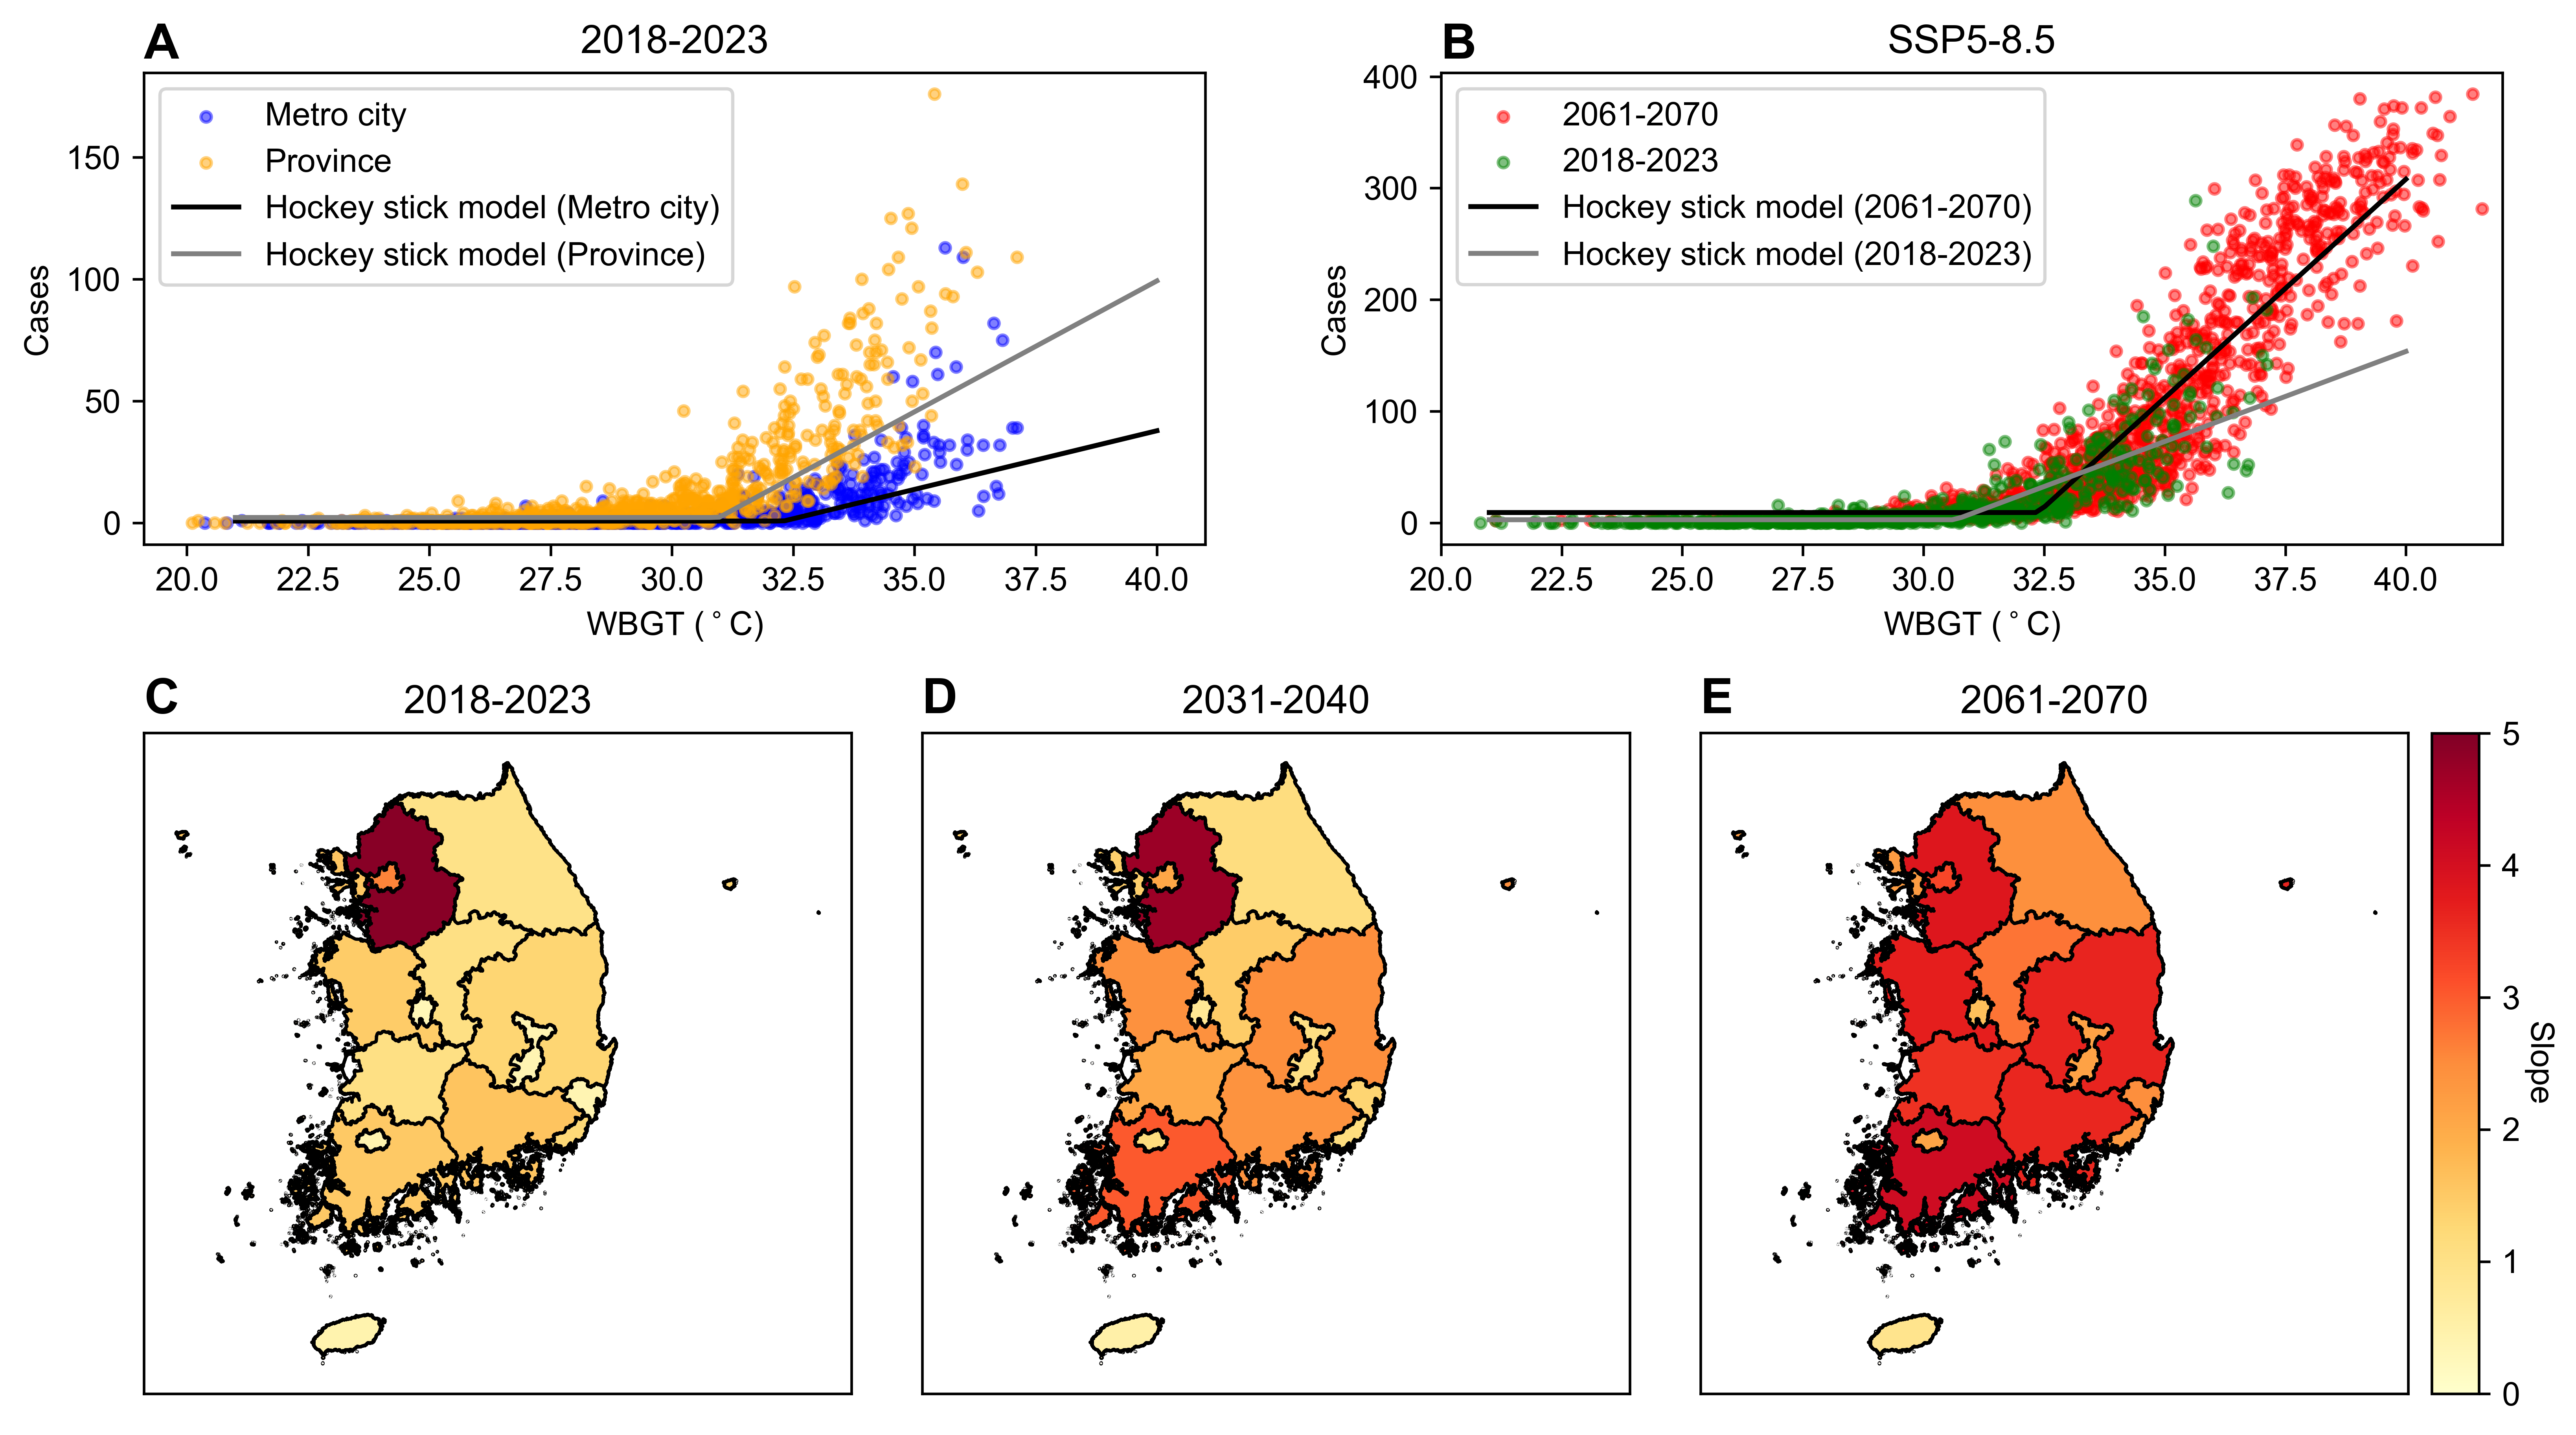

In [87]:
date_format = mdates.DateFormatter('%m-%d')

gs=[0]*6
ax=[0]*6

fig=plt.figure(figsize=(10, 8),dpi=600)

gs[0]=fig.add_gridspec(nrows=1,ncols=1,top=1, bottom=0.75,left=0, right=0.45)
gs[1]=fig.add_gridspec(nrows=1,ncols=1,top=1, bottom=0.75,left=0.55, right=1)
gs[2]=fig.add_gridspec(nrows=1,ncols=1,top=0.7, bottom=0.25,left=0, right=0.30)
gs[3]=fig.add_gridspec(nrows=1,ncols=1,top=0.7, bottom=0.25,left=0.33, right=0.63)
gs[4]=fig.add_gridspec(nrows=1,ncols=1,top=0.7, bottom=0.25,left=0.66, right=0.96)
gs[5]=fig.add_gridspec(nrows=1,ncols=1,top=0.65, bottom=0.30,left=0.97, right=0.99)


i=0
ax[i]=fig.add_subplot(gs[i][0])
ax[i].scatter(metro_data_drop['wbgt'],metro_data_drop['case'],color='blue',s=10,label='Metro city', alpha=0.5)
ax[i].scatter(urban_data_drop['wbgt'],urban_data_drop['case'],color='orange',s=10,label='Province', alpha=0.5)

ax[i].plot(x_fit,ym_fit_list[0],color='black',label=f'Hockey stick model (Metro city)')
ax[i].plot(x_fit,ym_fit_list[1],color='gray',label=f'Hockey stick model (Province)')
ax[i].set_title('2018-2023', fontsize=12)

ax[i].set_xlabel(r'WBGT ($^\circ$C)')
ax[i].set_ylabel('Cases')
ax[i].legend()
ax[i].text(0,1.03,'{}'.format(string.ascii_uppercase[i]),transform=ax[i].transAxes,weight='bold',fontsize=15)


i=1
ax[i]=fig.add_subplot(gs[i][0])

colors=['gray','black','red','blue']
years=['','','2056-2072','2018-2023']


j=4
tmp_result=ssp_585_result
tmp_fit=ssp_585_fit
tmp_data=df_585[df_585['period']==j]

ax[i].scatter(tmp_data['wbgt'],tmp_data['case'],color='red',s=10,label='2061-2070', alpha=0.5)

j=0
# ax[i].scatter(data_loc2_drop['wbgt'],data_loc2_drop['case'],color='green',s=10, label='2018-2023',alpha=0.5)
# ax[i].plot(x_fit_585,base_fit,color='gray',label='Hockey stick model (2018-2023)')
# ax[i].axvline(x=t0, color='black', linestyle='--',label=f'Threshold : {t0:.2f}')

tmp_result=ssp_585_result
tmp_fit=ssp_585_fit
tmp_data=df_585[df_585['period']==j]

ax[i].scatter(tmp_data['wbgt'],tmp_data['case'],color='green',s=10,label='2018-2023', alpha=0.5)

ax[i].plot(x_fit_585,tmp_fit[4],color='black',label='Hockey stick model (2061-2070)')
ax[i].plot(x_fit_585,tmp_fit[0],color='gray',label='Hockey stick model (2018-2023)')


ax[i].set_title('SSP5-8.5')
ax[i].set_xlabel('WBGT ($^\circ$C)')
ax[i].set_ylabel('Cases')
ax[i].set_xlim(20,42)
ax[i].legend(ncols=1,loc='upper left')
ax[i].text(0,1.03,'{}'.format(string.ascii_uppercase[i]),transform=ax[i].transAxes,weight='bold',fontsize=15)


i=2
ax[i]=fig.add_subplot(gs[i][0])

korea_slope.plot(column=2023,cmap='YlOrRd',ax=ax[i], edgecolor='black',legend=False,vmin=0,vmax=5)
ax[i].set_title('2018-2023', fontsize=12)
ax[i].set_xticks([])
ax[i].set_yticks([])
ax[i].text(0,1.03,'{}'.format(string.ascii_uppercase[i]),transform=ax[i].transAxes,weight='bold',fontsize=15)

i=3
ax[i]=fig.add_subplot(gs[i][0])


korea_slope.plot(column=2040,cmap='YlOrRd',ax=ax[i], edgecolor='black',legend=False,vmin=0,vmax=5)
ax[i].set_title('2031-2040', fontsize=12)
ax[i].set_xticks([])
ax[i].set_yticks([])
ax[i].text(0,1.03,'{}'.format(string.ascii_uppercase[i]),transform=ax[i].transAxes,weight='bold',fontsize=15)

i=4
ax[i]=fig.add_subplot(gs[i][0])

im=korea_slope.plot(column=2070,cmap='YlOrRd',ax=ax[i], edgecolor='black',legend=False,vmin=0,vmax=5)

ax[i].set_title('2061-2070', fontsize=12)
ax[i].set_xticks([])
ax[i].set_yticks([])
ax[i].text(0,1.03,'{}'.format(string.ascii_uppercase[i]),transform=ax[i].transAxes,weight='bold',fontsize=15)

i=5
ax[i]=fig.add_subplot(gs[i][0])
# ax[i].axis("off")  # 축 숨기기
cbar = fig.colorbar(im.collections[0], cax=ax[i],shrink=0.5,aspect=20, pad=0.02)
cbar.set_label('Slope', fontsize=10,labelpad=10,rotation=270)

# divider=make_axes_locatable(ax[i])

# im=korea_threshold.plot(column=2070,cmap='Reds',ax=ax[i], edgecolor='black',legend=False,vmin=28,vmax=32)
# cax=divider.append_axes("right",size="5%",pad="5%")
# cbar = fig.colorbar(im.collections[0], ax=ax[i],shrink=0.5,aspect=20, pad=0.02)
# cbar.set_label('threshold of Hockey stick model', fontsize=10,labelpad=10,rotation=270)

# fig.savefig(savefolder+'/FigS1.tiff', format='tiff', bbox_inches='tight', pad_inches=.1, dpi=set_dpi)
fig.savefig(savefolder+'/Figure 10.jpg', format='jpg', bbox_inches='tight', pad_inches=.1, dpi=set_dpi)

plt.show()

In [88]:
korea_threshold=pd.merge(korea,threshold_df,on='region')

In [89]:
korea_threshold

CTPRVN_CD         CTP_ENG_NM CTP_KOR_NM  \
0         11              Seoul      서울특별시   
1         26              Busan      부산광역시   
2         27              Daegu      대구광역시   
3         28            Incheon      인천광역시   
4         29            Gwangju      광주광역시   
5         30            Daejeon      대전광역시   
6         31              Ulsan      울산광역시   
7         41        Gyeonggi-do        경기도   
8         43  Chungcheongbuk-do       충청북도   
9         44  Chungcheongnam-do       충청남도   
10        45       Jeollabuk-do       전라북도   
11        46        Jellanam-do       전라남도   
12        47   Gyeongsangbuk-do       경상북도   
13        48   Gyeongsangnam-do       경상남도   
14        50            Jeju-do    제주특별자치도   
15        51         Gangwon-do    강원특별자치도   

                                             geometry  \
0   POLYGON ((127.12667 37.46863, 127.12667 37.468...   
1   MULTIPOLYGON (((129.12699 35.15348, 129.12696 ...   
2   POLYGON ((128.47278 35.83345, 128.47278 35.833...   
3   MULTIPOLYGON (((125.79162 36.92244, 125.79169 ...   
4   POLYGON ((126.76029 35.2587, 126.76105 35.2585...   
5   POLYGON ((127.39892 36.4891, 127.40016 36.4879...   
6   MULTIPOLYGON (((129.34886 35.3741, 129.34886 3...   
7   MULTIPOLYGON (((126.73088 37.04639, 126.73141 ...   
8   POLYGON ((127.98141 37.25688, 127.98188 37.256...   
9   MULTIPOLYGON (((126.08993 36.20137, 126.0899 3...   
10  MULTIPOLYGON (((126.4276 35.44847, 126.42764 3...   
11  MULTIPOLYGON (((126.92181 33.98876, 126.92178 ...   
12  MULTIPOLYGON (((129.48696 35.7384, 129.487 35....   
13  MULTIPOLYGON (((128.53941 34.75732, 128.53945 ...   
14  MULTIPOLYGON (((126.26745 33.11373, 126.26737 ...   
15  MULTIPOLYGON (((129.34455 37.1713, 129.34456 3...   

                  center_point     region       2023       2040       2070  
0   POINT (126.99182 37.55192)      Seoul  29.596197  30.116354  31.425709  
1   POINT (129.06057 35.20165)      Busan  28.653989  27.716190  30.231574  
2   POINT (128.59936 35.96984)      Daegu  29.619681  29.243171  31.607161  
3   POINT (126.37823 37.58312)    Incheon  27.658073  28.284162  29.973440  
4   POINT (126.83543 35.15573)    Gwangju  30.026427  29.909702  31.757970  
5   POINT (127.39404 36.33976)    Daejeon  29.715886  28.823763  30.906805  
6   POINT (129.23797 35.55381)      Ulsan  28.364661  27.631989  30.042643  
7   POINT (127.18064 37.53418)   Gyeonggi  29.676068  29.139561  28.729382  
8   POINT (127.83135 36.73878)   Chungbuk  29.153739  29.016453  31.356380  
9   POINT (126.84858 36.52962)   Chungnam  29.032352  29.129079  30.972793  
10  POINT (127.14273 35.71581)    Jeonbuk  28.863311  29.711694  32.069917  
11  POINT (126.90133 34.87595)    Jeonnam  28.509692  29.316887  31.671021  
12  POINT (128.75218 36.35454)  Gyeongbuk  28.277819  28.347499  30.428345  
13  POINT (128.26132 35.32427)  Gyeongnam  29.133128  28.975971  31.341467  
14  POINT (126.55383 33.38694)       Jeju  27.284983  27.907241  29.089986  
15    POINT (128.301 37.71913)    Gangwon  28.427346  27.786579  30.533251

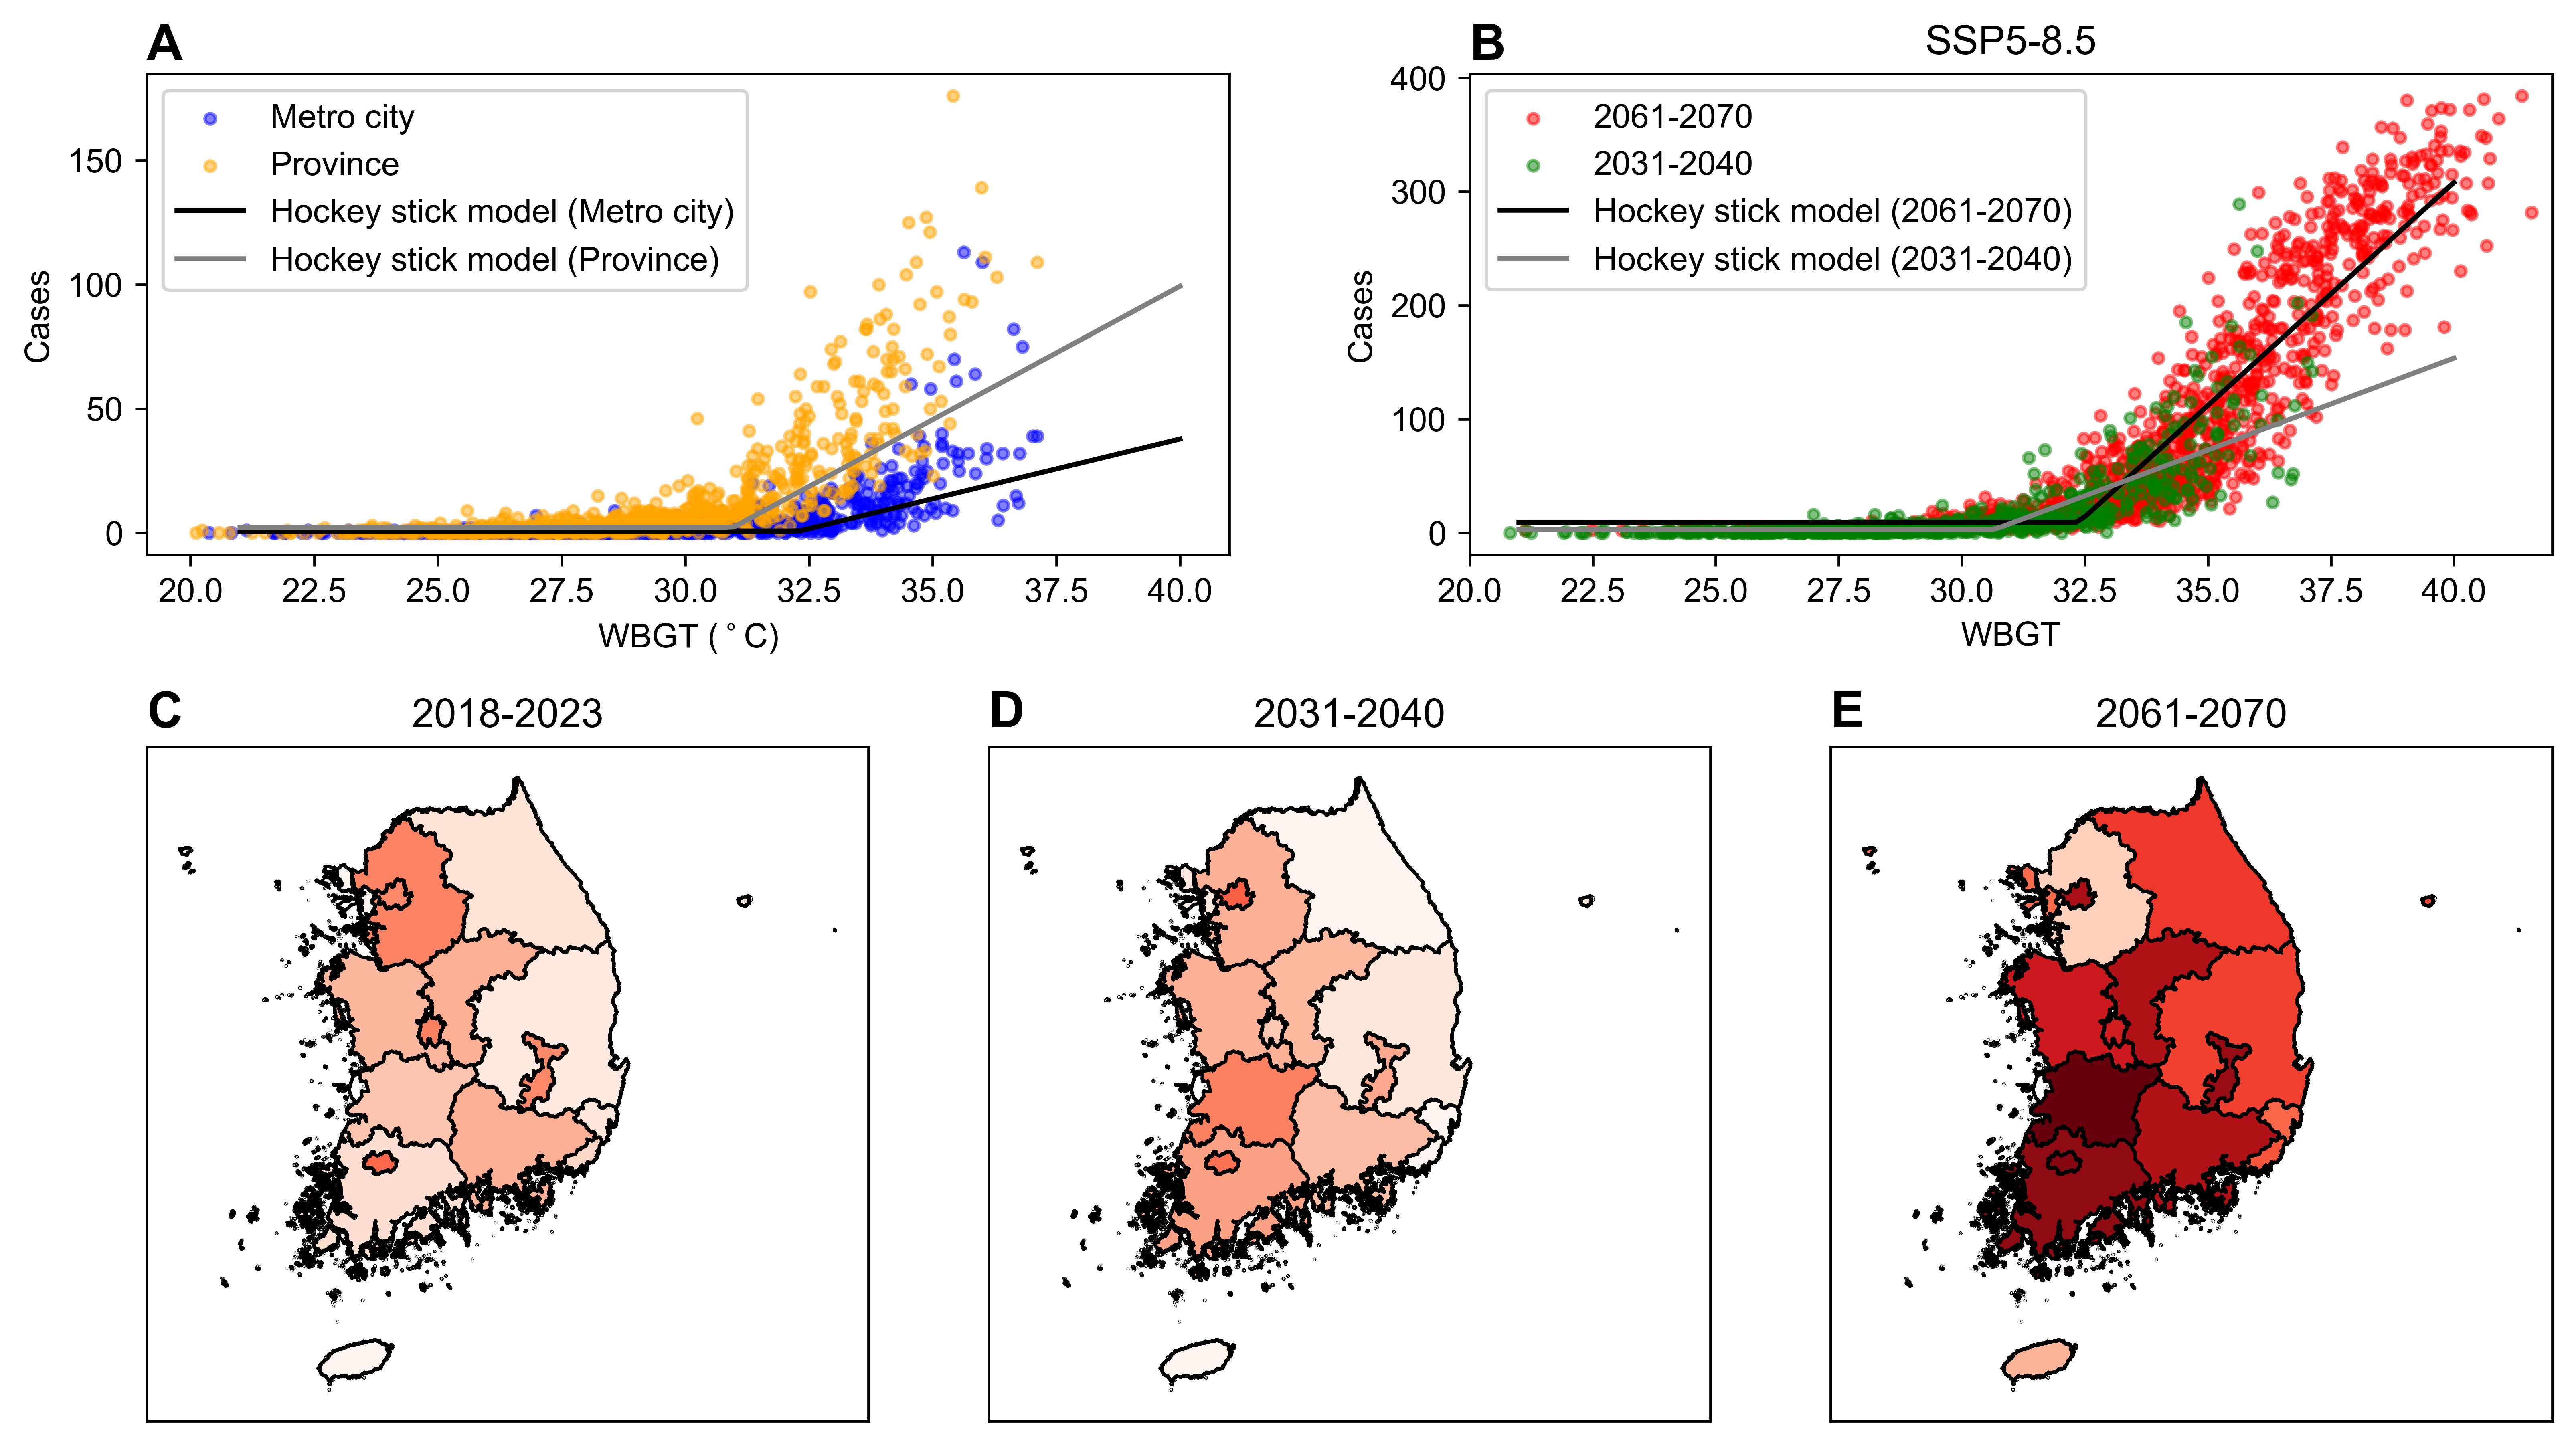

In [90]:
date_format = mdates.DateFormatter('%m-%d')

gs=[0]*5
ax=[0]*5

fig=plt.figure(figsize=(10, 8),dpi=600)

gs[0]=fig.add_gridspec(nrows=1,ncols=1,top=1, bottom=0.75,left=0, right=0.45)
gs[1]=fig.add_gridspec(nrows=1,ncols=1,top=1, bottom=0.75,left=0.55, right=1)
gs[2]=fig.add_gridspec(nrows=1,ncols=1,top=0.7, bottom=0.25,left=0, right=0.30)
gs[3]=fig.add_gridspec(nrows=1,ncols=1,top=0.7, bottom=0.25,left=0.35, right=0.65)
gs[4]=fig.add_gridspec(nrows=1,ncols=1,top=0.7, bottom=0.25,left=0.7, right=1)


i=0
ax[i]=fig.add_subplot(gs[i][0])
ax[i].scatter(metro_data_drop['wbgt'],metro_data_drop['case'],color='blue',s=10,label='Metro city', alpha=0.5)
ax[i].scatter(urban_data_drop['wbgt'],urban_data_drop['case'],color='orange',s=10,label='Province', alpha=0.5)

ax[i].plot(x_fit,ym_fit_list[0],color='black',label=f'Hockey stick model (Metro city)')
ax[i].plot(x_fit,ym_fit_list[1],color='gray',label=f'Hockey stick model (Province)')

ax[i].set_xlabel(r'WBGT ($^\circ$C)')
ax[i].set_ylabel('Cases')
ax[i].legend()
ax[i].text(0,1.03,'{}'.format(string.ascii_uppercase[i]),transform=ax[i].transAxes,weight='bold',fontsize=15)


i=1
ax[i]=fig.add_subplot(gs[i][0])

colors=['gray','black','red','blue']
years=['','','2056-2072','2018-2023']


j=4
tmp_result=ssp_585_result
tmp_fit=ssp_585_fit
tmp_data=df_585[df_585['period']==j]

ax[i].scatter(tmp_data['wbgt'],tmp_data['case'],color='red',s=10,label='2061-2070', alpha=0.5)

j=0
tmp_result=ssp_585_result
tmp_fit=ssp_585_fit
tmp_data=df_585[df_585['period']==j]

ax[i].scatter(tmp_data['wbgt'],tmp_data['case'],color='green',s=10,label='2031-2040', alpha=0.5)

ax[i].plot(x_fit_585,tmp_fit[4],color='black',label='Hockey stick model (2061-2070)')
ax[i].plot(x_fit_585,tmp_fit[0],color='gray',label='Hockey stick model (2031-2040)')



    
ax[i].set_title('SSP5-8.5')
ax[i].set_xlabel('WBGT')
ax[i].set_ylabel('Cases')
ax[i].set_xlim(20,42)
ax[i].legend(ncols=1,loc='upper left')
ax[i].text(0,1.03,'{}'.format(string.ascii_uppercase[i]),transform=ax[i].transAxes,weight='bold',fontsize=15)


i=2
ax[i]=fig.add_subplot(gs[i][0])
# ax[i].margins(0)
# ax[i].set_aspect('auto')
# divider=make_axes_locatable(ax[i])

korea_threshold.plot(column=2023,cmap='Reds',ax=ax[i], edgecolor='black',legend=False,vmin=28,vmax=32)
ax[i].set_title('2018-2023', fontsize=12)
ax[i].set_xticks([])
ax[i].set_yticks([])
ax[i].text(0,1.03,'{}'.format(string.ascii_uppercase[i]),transform=ax[i].transAxes,weight='bold',fontsize=15)

i=3
ax[i]=fig.add_subplot(gs[i][0])
# divider=make_axes_locatable(ax[i])

korea_threshold.plot(column=2040,cmap='Reds',ax=ax[i], edgecolor='black',legend=False,vmin=28,vmax=32)
ax[i].set_title('2031-2040', fontsize=12)
ax[i].set_xticks([])
ax[i].set_yticks([])
ax[i].text(0,1.03,'{}'.format(string.ascii_uppercase[i]),transform=ax[i].transAxes,weight='bold',fontsize=15)

i=4
ax[i]=fig.add_subplot(gs[i][0])
# divider=make_axes_locatable(ax[i])

im=korea_threshold.plot(column=2070,cmap='Reds',ax=ax[i], edgecolor='black',legend=False,vmin=28,vmax=32)
# cax=divider.append_axes("right",size="5%",pad="5%")
# cbar = fig.colorbar(im.collections[0], ax=ax[i],shrink=0.5,aspect=20, pad=0.02)
# cbar.set_label('threshold of Hockey stick model', fontsize=10,labelpad=10,rotation=270)
# # 컬러바의 위치를 조정 (지도 내부 오른쪽 아래로 설정)
# cbar.ax.set_position([ax[i].get_position().x1 - 0.07,  # x 위치 (오른쪽으로 이동)
#                       ax[i].get_position().y0 + 0.02,  # y 위치 (약간 위로)
#                       0.02,  # width (컬러바 너비)
#                       ax[i].get_position().height * 0.6])  # height (컬러바 높이 조정)
ax[i].set_title('2061-2070', fontsize=12)
ax[i].set_xticks([])
ax[i].set_yticks([])
ax[i].text(0,1.03,'{}'.format(string.ascii_uppercase[i]),transform=ax[i].transAxes,weight='bold',fontsize=15)


# fig.savefig(savefolder+'/FigS1.tiff', format='tiff', bbox_inches='tight', pad_inches=.1, dpi=set_dpi)
# fig.savefig(savefolder+'/Fig5.jpg', format='jpg', bbox_inches='tight', pad_inches=.1, dpi=set_dpi)
plt.show()